This is for Bayes Discord questions. Some code taken from the repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
from scipy.special import logit
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Fixed effects model with a Normal likelihood

In [48]:
df_howell = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/Howell1.csv",
    delimiter=";",
)

df_howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<IPython.core.display.Javascript object>

In [49]:
df_howell.shape

(544, 4)

<IPython.core.display.Javascript object>

I'm going to introduce a wrinkle. Let's assume that there's a `village` variable, associated with each individual, just so that we have a categorical variable that we can cluster on. I'm going to assume 9 different villages, of varying size. Here's my hacky way of doing it.

In [94]:
# Create a vector of 8 numbers of varying size (I should set a seed so this is reproducible)
village_sizes = [round(i) for i in np.random.normal(loc=544 / 9, scale=30, size=8)]
village_sizes.append(len(df_howell) - sum(village_sizes))

<IPython.core.display.Javascript object>

In [95]:
village_sizes
# [33, 28, 16, 69, 5, 58, 116, 58, 161]

[33, 28, 16, 69, 5, 58, 116, 58, 161]

<IPython.core.display.Javascript object>

In [105]:
villages = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]
village_list = list()
for i, j in enumerate(villages):
    village_list += village_sizes[i] * [j]

<IPython.core.display.Javascript object>

In [114]:
df_howell["village"] = village_list
df_howell["village_cat"] = pd.Categorical(df_howell["village"]).codes

# Filter so that only adults will be modeled
df_howell2 = df_howell[df_howell["age"] >= 18]
df_howell2.head()

,height,weight,age,male,village,village_cat
0,151.765,47.825606,63.0,1,A,0
1,139.700,36.485807,63.0,0,A,0
2,136.525,31.864838,65.0,0,A,0
3,156.845,53.041914,41.0,1,A,0
4,145.415,41.276872,51.0,0,A,0


<IPython.core.display.Javascript object>

We can use an index variable for each village and apply a regularizing prior.

**Next: flesh out the model and look at impact of sample size.**

We can update the priors as such. Let's keep the model simple and confine the index variable to the intercept term. Perhaps there is some variation such that some villages have taller people than others. (Yes, this example is very contrived but this is just for the purposes of setting up the model.) We would use a regularizing prior but specify a numerical value.

$$ h_{i} \text{ ~ Normal}(\mu_{i}, \sigma)$$
$$ \mu_{i} = \alpha_{\text{VILLAGE}[i]} + \beta x$$
$$ \alpha  \text{ ~ Normal}(178, 20)$$
$$ \beta \text{ ~ Log-Normal}(0, 1)$$
$$ \sigma \text{ ~ Exponential}(1)$$


In [115]:
xbar = df_howell["weight"].mean()
print(xbar)

35.610617592463235


<IPython.core.display.Javascript object>

In [116]:
with pm.Model() as m1:

    # Priors
    a = pm.Normal("a", mu=178, sigma=20, shape=len(df_howell["village_cat"].unique()))
    b = pm.Lognormal("b", 0, 1)
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = a[df_howell["village_cat"]] + b * (df_howell["weight"] - xbar)

    # Likelihood
    h = pm.Normal("h", mu=mu, sigma=sigma, observed=df_howell["height"])

    trace_m1 = pm.sample(draws=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
INFO:pymc3:NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

In [117]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],140.388,1.571,137.891,142.823,0.023,0.016,4748.0,4738.0,4784.0,3082.0,1.0
a[1],138.048,1.688,135.362,140.741,0.024,0.017,4798.0,4793.0,4790.0,3258.0,1.0
a[2],140.242,2.346,136.577,144.056,0.033,0.024,4930.0,4910.0,4944.0,2971.0,1.0
a[3],139.829,1.070,138.115,141.505,0.015,0.011,4812.0,4812.0,4787.0,3274.0,1.0
a[4],142.493,4.143,135.707,148.800,0.054,0.038,5831.0,5802.0,5825.0,3209.0,1.0
a[5],138.231,1.183,136.252,140.050,0.015,0.011,6182.0,6182.0,6184.0,3329.0,1.0
a[6],140.261,0.858,138.930,141.653,0.013,0.009,4664.0,4664.0,4666.0,3060.0,1.0
a[7],133.679,1.221,131.718,135.652,0.018,0.012,4852.0,4852.0,4856.0,3239.0,1.0
a[8],137.558,0.707,136.435,138.668,0.010,0.007,5341.0,5338.0,5315.0,3013.0,1.0
b,1.728,0.028,1.686,1.773,0.000,0.000,5154.0,5154.0,5133.0,3442.0,1.0


<IPython.core.display.Javascript object>

Now we get an average height for each village. But one thing that you can see is how the standard deviations vary for each village. This is due to the differences in sample size.

[Text(0.5, 0, 'sample_size'),
 Text(0, 0.5, 'sigma'),
 Text(0.5, 1.0, 'Sample size vs. Sigma')]

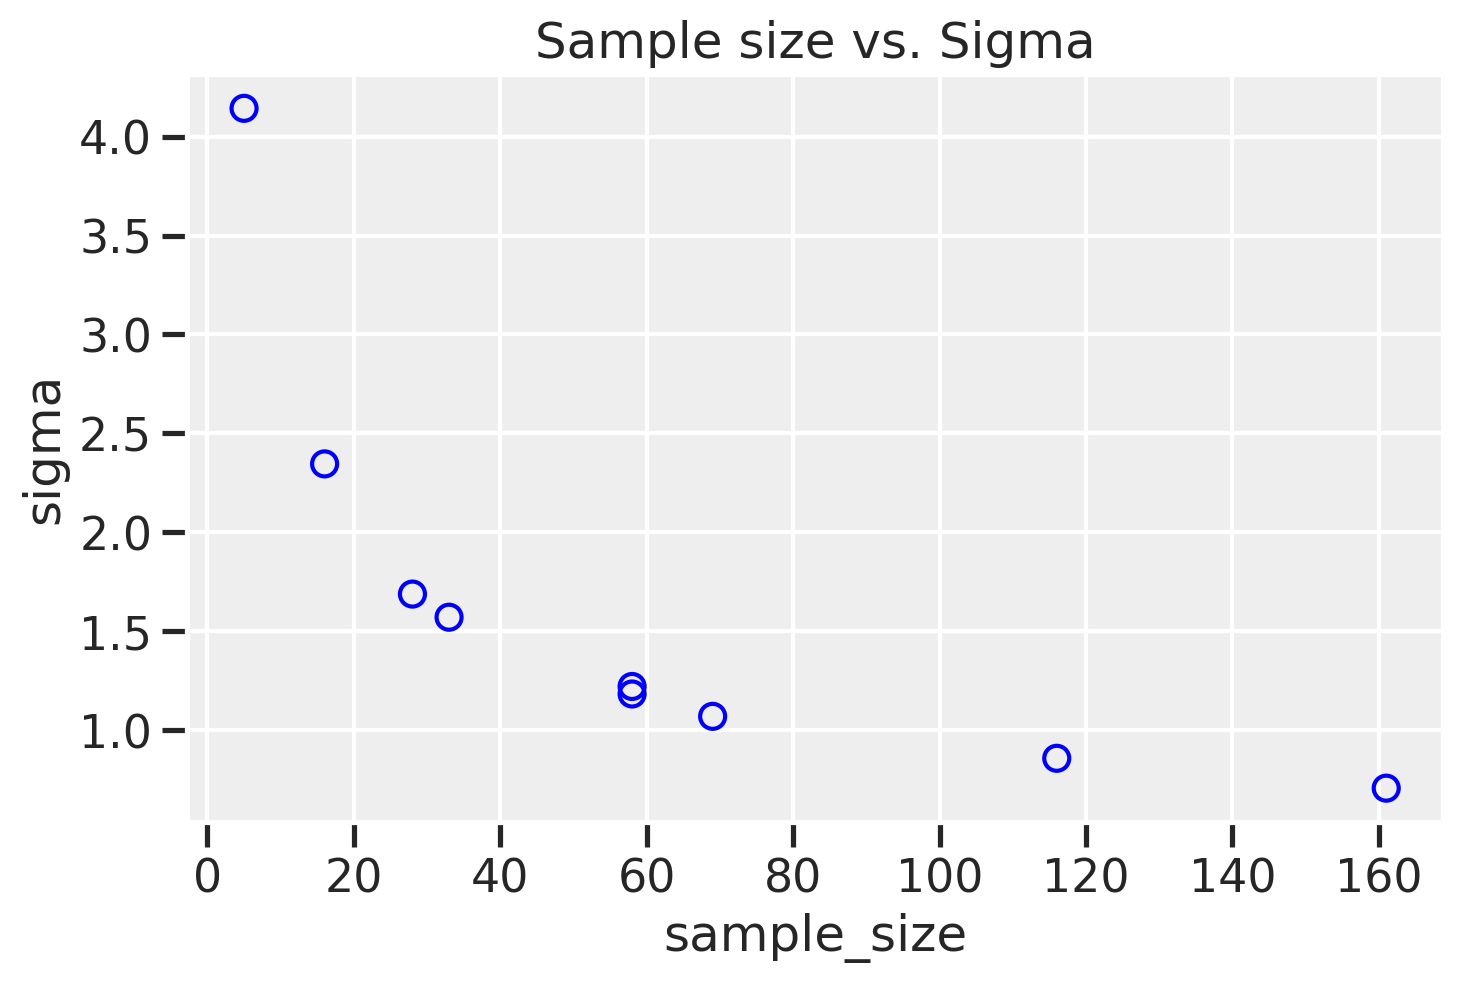

<IPython.core.display.Javascript object>

In [126]:
df_temp = az.summary(trace_m1).iloc[0:9, 0:2]
df_temp["sample_size"] = village_sizes

f, ax1 = plt.subplots()
ax1.scatter(df_temp["sample_size"], df_temp["sd"], facecolors="none", edgecolors="blue")
ax1.set(xlabel="sample_size", ylabel="sigma", title="Sample size vs. Sigma")

# Multilevel model with a Normal likelihood

Now let's do a multilevel model that can use partial pooling and get better estimates.

In contrast to a regularizing prior where we specify numerical values, we now use an *adaptive, regularizing prior* to allow partial pooling and impose shrinkage on the estimates.

$$ h_{i} \text{ ~ Normal}(\mu_{i}, \sigma_1)$$
$$ \mu_{i} = \alpha_{\text{VILLAGE}[i]} + \beta x$$
$$ \alpha  \text{ ~ Normal}(\bar{\alpha}, \sigma_2)$$
$$ \bar{\alpha}  \text{ ~ Normal}(178, 20)$$
$$ \beta \text{ ~ Log-Normal}(0, 1)$$
$$ \sigma_1 \text{ ~ Exponential}(1)$$
$$ \sigma_2 \text{ ~ Exponential}(1)$$


In [130]:
with pm.Model() as m2:

    # Priors/hyperprior
    a_bar = pm.Normal("a_bar", mu=178, sigma=20)  # no shape parameter here
    b = pm.Lognormal("b", 0, 1)
    sigma1 = pm.Exponential("sigma1", 1)
    sigma2 = pm.Exponential("sigma2", 1)

    # Adaptive prior
    a = pm.Normal(
        "a", mu=a_bar, sigma=sigma2, shape=len(df_howell["village_cat"].unique())
    )

    # Linear model
    mu = a[df_howell["village_cat"]] + b * (df_howell["weight"] - xbar)

    # Likelihood
    h = pm.Normal("h", mu=mu, sigma=sigma1, observed=df_howell["height"])

    trace_m2 = pm.sample(draws=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma2, sigma1, b, a_bar]
INFO:pymc3:NUTS: [a, sigma2, sigma1, b, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for

<IPython.core.display.Javascript object>

In [131]:
az.summary(trace_m2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,138.371,0.787,137.132,139.550,0.017,0.012,2198.0,2194.0,2284.0,2321.0,1.01
a[0],139.170,1.201,137.224,141.004,0.031,0.022,1504.0,1504.0,1507.0,2925.0,1.00
a[1],138.087,1.207,136.157,139.992,0.019,0.013,4168.0,4165.0,4147.0,2976.0,1.01
a[2],138.765,1.398,136.711,141.165,0.022,0.016,3904.0,3891.0,3917.0,2763.0,1.01
a[3],139.185,0.932,137.767,140.740,0.024,0.017,1485.0,1485.0,1460.0,1267.0,1.00
a[4],138.757,1.702,136.040,141.373,0.030,0.021,3266.0,3251.0,3401.0,2072.0,1.00
a[5],138.154,0.956,136.560,139.616,0.018,0.013,2904.0,2900.0,2870.0,2522.0,1.00
a[6],139.660,0.809,138.355,140.867,0.033,0.023,600.0,600.0,603.0,1131.0,1.01
a[7],135.579,1.344,133.713,137.992,0.079,0.056,290.0,286.0,276.0,405.0,1.01
a[8],137.724,0.663,136.684,138.732,0.017,0.012,1438.0,1433.0,1374.0,2811.0,1.00


<IPython.core.display.Javascript object>

In [138]:
df_temp2 = az.summary(trace_m2).iloc[1:10, 0:2]  # index 1:10 to account for a_bar
df_temp2["sample_size"] = village_sizes
df_temp2

,mean,sd,sample_size
a[0],139.170,1.201,33
a[1],138.087,1.207,28
a[2],138.765,1.398,16
a[3],139.185,0.932,69
a[4],138.757,1.702,5
a[5],138.154,0.956,58
a[6],139.660,0.809,116
a[7],135.579,1.344,58
a[8],137.724,0.663,161


<IPython.core.display.Javascript object>

<ipython-input-141-b1c3e94fab2f>:10: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


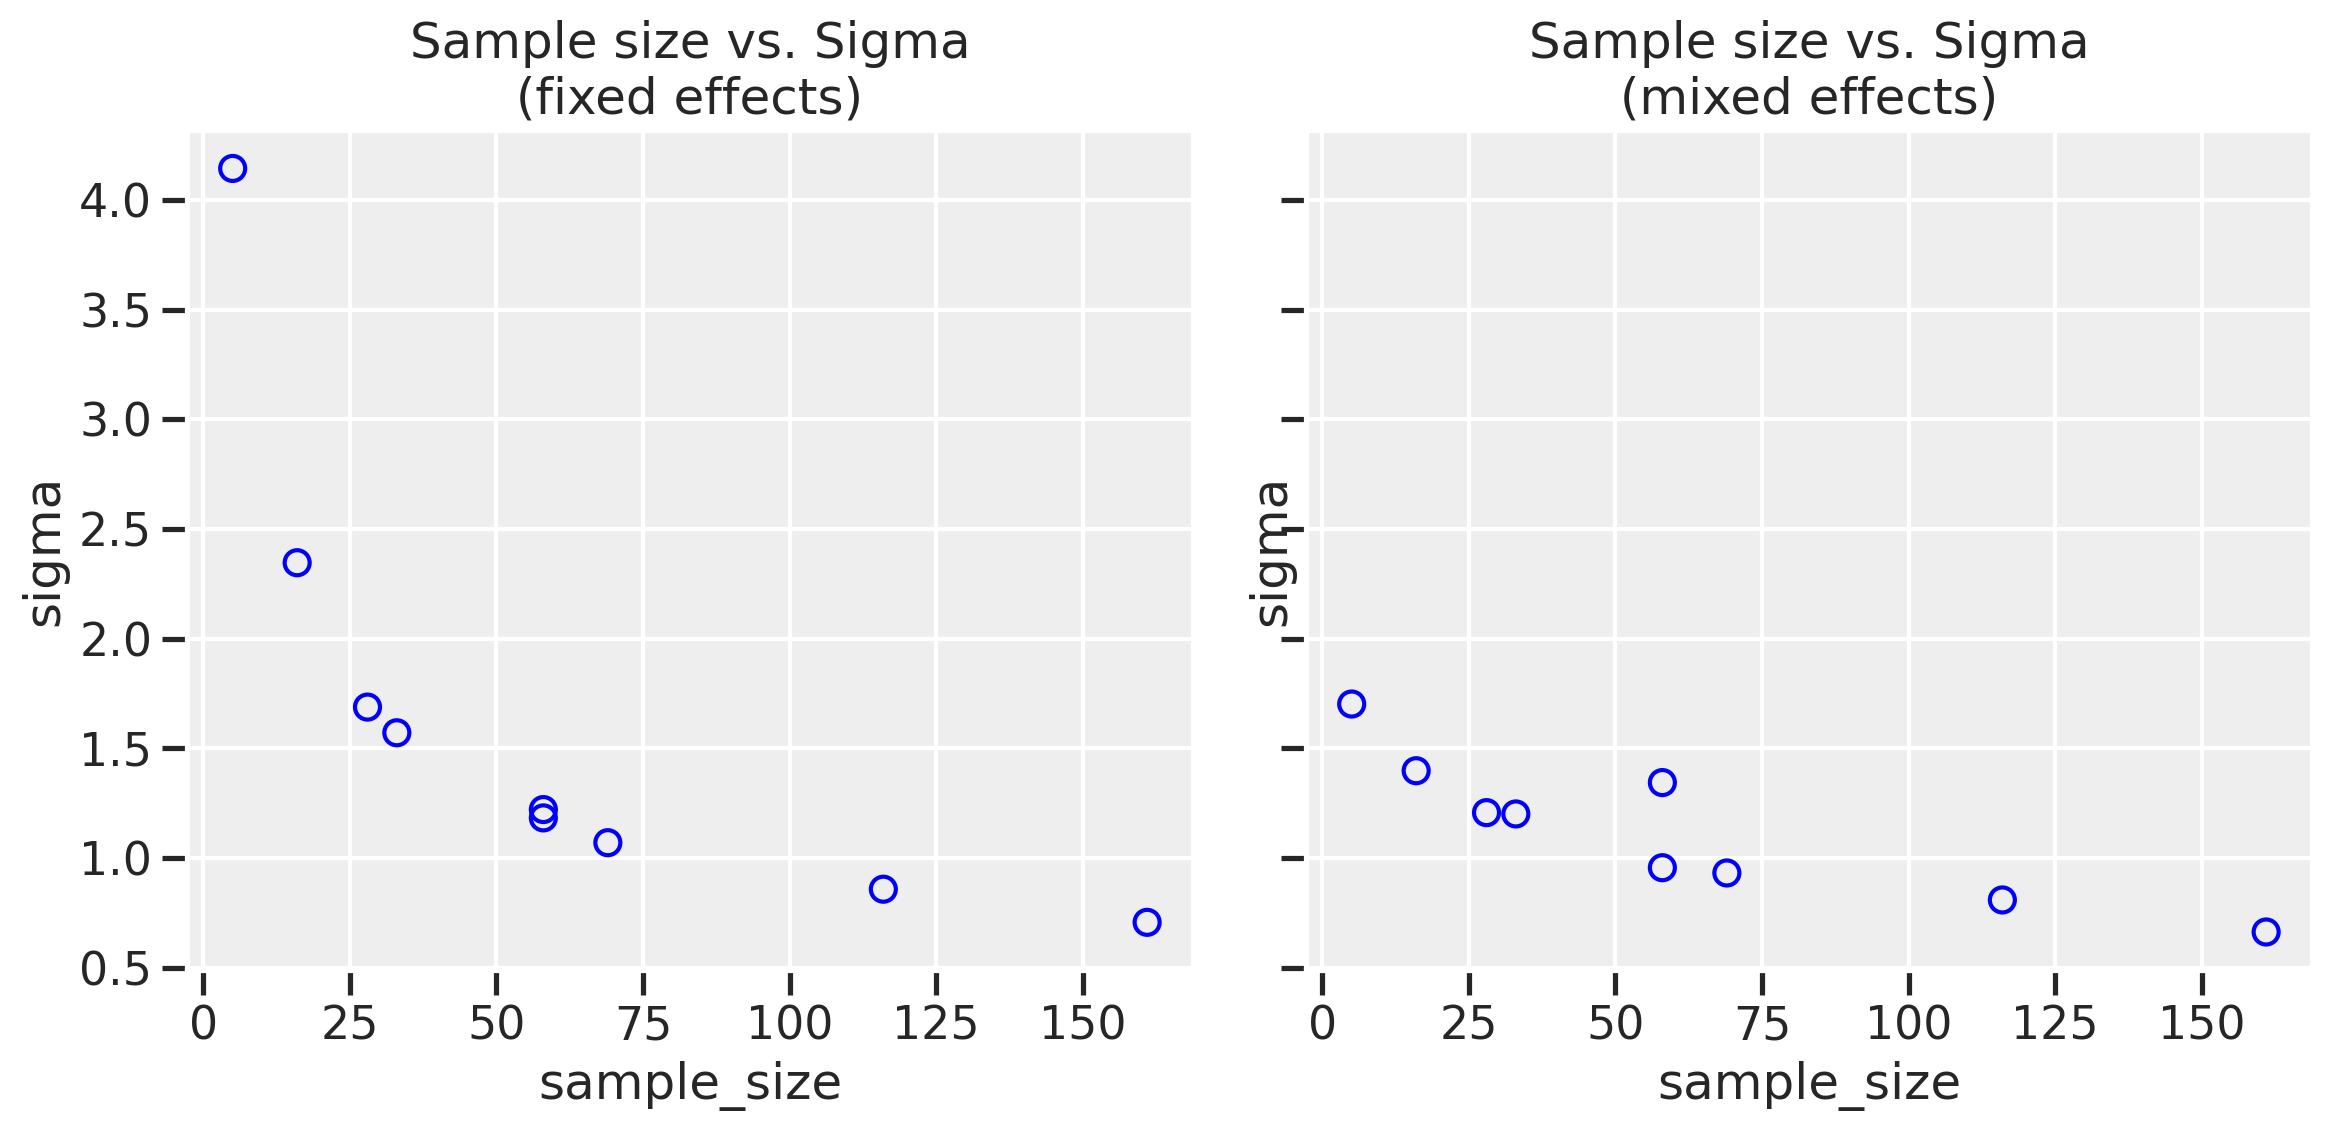

<IPython.core.display.Javascript object>

In [141]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
ax1.scatter(df_temp["sample_size"], df_temp["sd"], facecolors="none", edgecolors="blue")
ax1.set(
    xlabel="sample_size", ylabel="sigma", title="Sample size vs. Sigma\n(fixed effects)"
)

ax2.scatter(
    df_temp2["sample_size"], df_temp2["sd"], facecolors="none", edgecolors="blue"
)
ax2.set(
    xlabel="sample_size", ylabel="sigma", title="Sample size vs. Sigma\n(mixed effects)"
)

plt.tight_layout()

You can see that the pattern largely holds, but the sigmas are a lot smaller, especially those that had smaller sample size.

# How to make a non centered t(nu, 0, 1)

Question posed by Jan Christian.

Stan reference [here](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html).

A student-t distribution was used with the divorce dataset and referenced in R code 4.35 (page 234).

In [5]:
df_divorce = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/WaffleDivorce.csv",
    delimiter=";",
)
df_divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<IPython.core.display.Javascript object>

In [7]:
df_divorce["Marriage_std"] = standardize(df_divorce["Marriage"])
df_divorce["MedianAgeMarriage_std"] = standardize(df_divorce["MedianAgeMarriage"])
df_divorce["Divorce_std"] = standardize(df_divorce["Divorce"])
df_divorce.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Marriage_std,MedianAgeMarriage_std,Divorce_std
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,0.022874,-0.612445,1.671000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,1.565536,-0.693671,1.560044
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,0.049472,-0.206314,0.616916
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,1.671927,-1.424706,2.114824
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,-0.269700,0.605947,-0.936470


<IPython.core.display.Javascript object>

The book used the following model equation:

$$ D \text{ ~ StudentT}(2, \mu, \sigma) \tag{likelihood}$$
$$ \alpha \text{ ~ Normal}(0, 0.2) \tag{prior for average divorce rate}$$
$$ \beta_{M} \text{ ~ Normal}(0, 0.5) \tag{prior for beta marriage rate}$$
$$ \beta_{A} \text{ ~ Normal}(0, 0.5) \tag{prior for beta age}$$
$$ \sigma \text{ ~ Exponential}(1) \tag{scale}$$


The pymc code from the book was as follows:

In [12]:
with pm.Model() as m5_3t:

    # Priors
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = a + bM * df_divorce["Marriage_std"] + bA * df_divorce["MedianAgeMarriage_std"]

    # Likelihood
    D = pm.StudentT("D", nu=2, mu=mu, sigma=sigma, observed=df_divorce["Divorce_std"])

    trace_m5_3t = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [13]:
az.summary(trace_m5_3t)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.020,0.104,-0.135,0.193,0.002,0.002,3315.0,2071.0,3384.0,2444.0,1.0
bM,0.047,0.208,-0.305,0.355,0.004,0.003,2588.0,2138.0,2640.0,2310.0,1.0
bA,-0.694,0.152,-0.941,-0.462,0.003,0.002,2441.0,2441.0,2443.0,2612.0,1.0
sigma,0.587,0.087,0.444,0.715,0.002,0.001,3159.0,3094.0,3203.0,2678.0,1.0


<IPython.core.display.Javascript object>

For understanding, the multi-level model let's start with a very simple model that only has an intercept term. For the purposes of understanding the adaptive prior, we also need to change the problem quite a bit and look at a different level of detail. For the purposes of clustering, I'm going to use a state's time zone as a basis for grouping. (I'm only taking the first listed time zone if a state is in more than one (taken from [here](https://state.1keydata.com/time-zone-state.php).

In [23]:
df_timezone = pd.read_clipboard(header=None)
df_timezone.columns = ["state", "timezone"]
df_timezone.head()

,state,timezone
0,Alabama,Central Time Zone
1,Alaska,Alaska Time Zone
2,Arizona,Mountain Time Zone
3,Arkansas,Central Time Zone
4,California,Pacific Time Zone


<IPython.core.display.Javascript object>

In [37]:
# save for reproducibility
# df_timezone.to_csv(os.getcwd() + "/other_data/state_timezones.csv")

<IPython.core.display.Javascript object>

In [39]:
# Noted that Nevada isn't in the divorce dataset
df_divorce2 = pd.merge(df_divorce, df_timezone, left_on="Location", right_on="state")
df_divorce2["timezone_cat"] = pd.Categorical(df_divorce2["timezone"]).codes
df_divorce2["state_cat"] = pd.Categorical(df_divorce2["Location"]).codes
df_divorce2.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Marriage_std,MedianAgeMarriage_std,Divorce_std,state,timezone,timezone_cat,state_cat
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,0.022874,-0.612445,1.671000,Alabama,Central Time Zone,1,0
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,1.565536,-0.693671,1.560044,Alaska,Alaska Time Zone,0,1
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,0.049472,-0.206314,0.616916,Arizona,Mountain Time Zone,4,2
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,1.671927,-1.424706,2.114824,Arkansas,Central Time Zone,1,3
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,-0.269700,0.605947,-0.936470,California,Pacific Time Zone,5,4


<IPython.core.display.Javascript object>

$$ D \text{ ~ StudentT}(2, \mu, \sigma) \tag{likelihood}$$
$$ \alpha_{[\text{state}]} \text{ ~ Normal}(0, 0.2) \tag{prior for average divorce rate in each state}$$
$$ \sigma \text{ ~ Exponential}(1) \tag{scale}$$

In [43]:
with pm.Model() as m5_3t_int:

    # Priors
    a = pm.Normal("a", 0, 0.2, shape=len(df_divorce2["state_cat"]))
    sigma = pm.Exponential("sigma", 1)

    # Linear model
    mu = a[df_divorce2["state_cat"]]

    # Likelihood
    D = pm.StudentT("D", nu=2, mu=mu, sigma=sigma, observed=df_divorce2["Divorce_std"])

    trace_m5_3t_int = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]
INFO:pymc3:NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [44]:
az.summary(trace_m5_3t_int)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.054,0.189,-0.247,0.341,0.002,0.003,9574.0,1830.0,9624.0,2945.0,1.01
a[1],0.056,0.199,-0.245,0.379,0.002,0.003,8495.0,1799.0,8478.0,3013.0,1.00
a[2],0.047,0.197,-0.249,0.381,0.002,0.003,7379.0,1669.0,7375.0,2970.0,1.00
a[3],0.048,0.198,-0.258,0.367,0.002,0.004,10392.0,1532.0,10411.0,3077.0,1.00
a[4],-0.060,0.201,-0.382,0.254,0.002,0.004,10574.0,1548.0,10653.0,2423.0,1.00
a[5],0.061,0.201,-0.266,0.372,0.002,0.004,10356.0,1548.0,10411.0,2703.0,1.00
a[6],-0.054,0.202,-0.373,0.271,0.002,0.004,10323.0,1524.0,10252.0,2799.0,1.00
a[7],-0.039,0.191,-0.323,0.296,0.002,0.004,11933.0,1458.0,11867.0,2742.0,1.00
a[8],-0.051,0.199,-0.361,0.269,0.002,0.003,10530.0,1667.0,10487.0,2596.0,1.00
a[9],0.057,0.200,-0.273,0.363,0.002,0.004,11650.0,1497.0,11719.0,2593.0,1.00


<IPython.core.display.Javascript object>

# A multi-level model with an adaptive prior

Now let's use the intercept only model to use a multi-level model with an adaptive prior, clustered by whether it's in the South.

We can update the priors as such.

$$ D \text{ ~ StudentT}(2, \mu, \sigma)$$
$$ \alpha_{j} \text{ ~ Normal}(\bar{\alpha}, \sigma)$$
$$ \bar{\alpha} \text{ ~ Normal}(0, 1.5)$$
$$ \sigma \text{ ~ Exponential}(1)$$


We can update the priors as such.

$$ D \text{ ~ StudentT}(2, \mu, \sigma)$$
$$ \alpha_{j} \text{ ~ Normal}(\bar{\alpha}, \sigma)$$
$$ \bar{\alpha} \text{ ~ Normal}(0, 1.5)$$
$$ \sigma \text{ ~ Exponential}(1)$$


I'm having a mental block as to what the sigma for equations 5, 6, and 8 should be.

## Data exploration and setup

In [5]:
df_bangladesh = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/bangladesh.csv",
    delimiter=";",
)
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


<IPython.core.display.Javascript object>

In [6]:
print("shape of df: ", df_bangladesh.shape)

shape of df:  (1934, 6)


<IPython.core.display.Javascript object>

Per the homework, fix the district variable since it is not a contiguous set of integers.. Luckily, this is easy enough to do with `pd.Categorical`.

In [7]:
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes

<IPython.core.display.Javascript object>

In [8]:
# inspect and see that it's now 0-indexed for Python

print(
    "df head: ", df_bangladesh[["district", "district_code"]].drop_duplicates().head()
)

# and also that it accounts for missing district 54
print(
    "df tail: ", df_bangladesh[["district", "district_code"]].drop_duplicates().tail(10)
)

df head:       district  district_code
0           1              0
117         2              1
137         3              2
139         4              3
169         5              4
df tail:        district  district_code
1622        51             50
1659        52             51
1720        53             52
1739        55             53
1745        56             54
1790        57             55
1817        58             56
1850        59             57
1860        60             58
1892        61             59


<IPython.core.display.Javascript object>

In [9]:
# Look outcome variable
df_bangladesh["use.contraception"].value_counts()

0    1175
1     759
Name: use.contraception, dtype: int64

<IPython.core.display.Javascript object>

## Fixed-effects model

Predict `use.contraception`. Since there are two outcomes, it makes sense to use a binomial GLM for this problem. We'll use an index variable for district and it will be an intercept only model.

**Model `mfe` equation**

$$C_i \text{ ~ } \text{Binomial}(1, p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(0, 1.5) \tag{regularizing prior}$$

In [10]:
with pm.Model() as mfe:

    # alpha prior, one for each district
    a = pm.Normal("a", 0, 1.5, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [11]:
# Preview dataset
az.summary(trace_mfe).head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.052,0.205,-1.389,-0.730,0.002,0.002,10791.0,8837.0,11082.0,2622.0,1.0
a[1],-0.584,0.452,-1.287,0.134,0.005,0.005,9885.0,4432.0,9897.0,2824.0,1.0
a[2],1.240,1.156,-0.647,2.980,0.012,0.014,8647.0,3240.0,8900.0,2517.0,1.0
a[3],-0.003,0.362,-0.572,0.579,0.004,0.007,9690.0,1409.0,9763.0,2666.0,1.0
a[4],-0.569,0.330,-1.077,-0.020,0.004,0.003,8362.0,4628.0,8431.0,2847.0,1.0


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

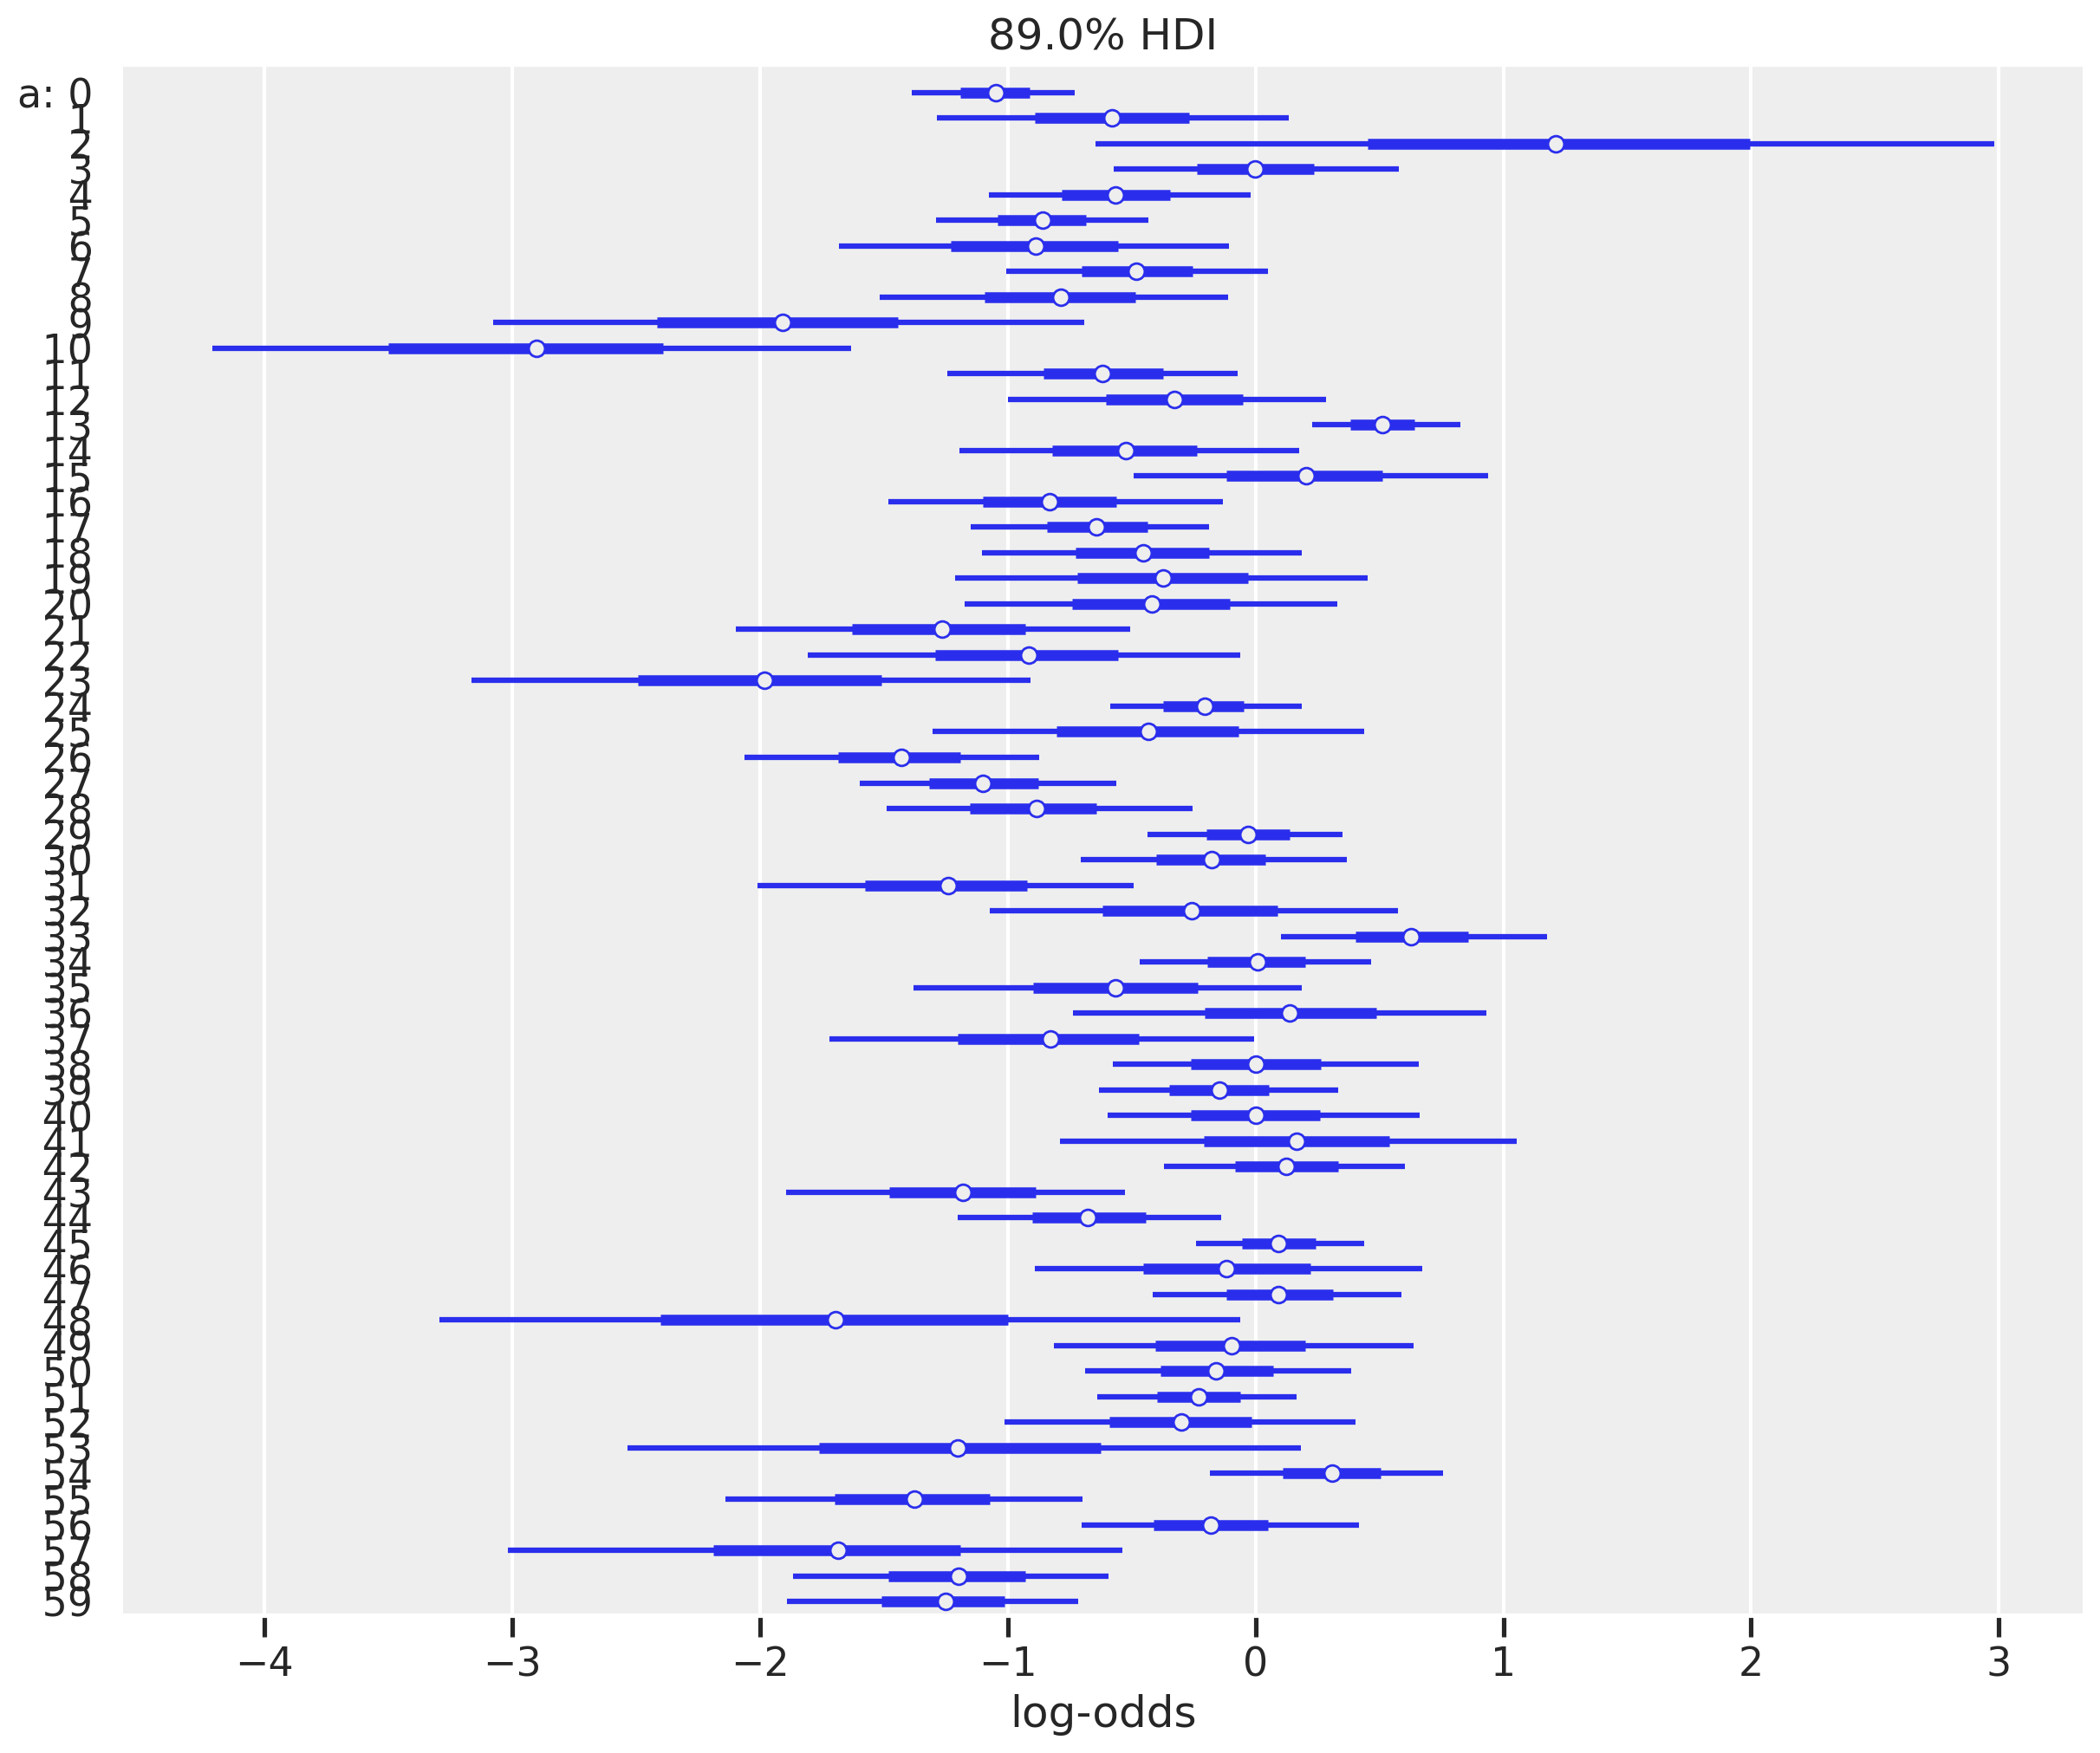

<IPython.core.display.Javascript object>

In [12]:
f, ax1 = plt.subplots(figsize=(12, 10))
az.plot_forest(trace_mfe, combined=True, ax=ax1)
ax1.set_xlabel("log-odds")

The results indicate that some districts are much less likely to use contraception (negative log-odds) than other districts (log-odds that span zero or are wholly positive).

This is seen by looking at the raw data. For example, the district indexed 10 is the most negative in terms of log-odds while index 2 is most positive. In index 10, there is no woman that has used contraception.

In [13]:
df_bangladesh[df_bangladesh["district_code"] == 10]

,woman,district,use.contraception,living.children,age.centered,urban,district_code
364,365,11,0,1,-9.5599,0,10
365,366,11,0,1,-8.5599,0,10
366,367,11,0,2,-5.5599,0,10
367,368,11,0,2,18.4400,0,10
368,369,11,0,1,-8.5599,0,10
369,370,11,0,1,-9.5599,0,10
370,371,11,0,1,-12.5590,0,10
371,372,11,0,1,3.4400,0,10
372,373,11,0,1,-8.5599,0,10
373,374,11,0,4,19.4400,0,10


<IPython.core.display.Javascript object>

## Mixed-effects model

Now let's use a mixed effects model where information is allowed to pool between clusters. This would make more sense since there's a varying number of women in each district.

In [14]:
df_bangladesh.groupby("district_code").count().iloc[:, 0].head(10)

district_code
0    117
1     20
2      2
3     30
4     39
5     65
6     18
7     37
8     23
9     13
Name: woman, dtype: int64

<IPython.core.display.Javascript object>

 For example, district index 2 has only 2 people. We identified that as a district that is most likely to use contraception in the fixed effects model but now we'd place less confidence on this point due to the low number. The mixed effects model will account for this.

**Model `mme` equation**

$$C_i \text{ ~ } \text{Binomial}(1, p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha_j} \text{ ~ } \text{Normal}(0, 1.5) \tag{regularizing prior}$$

$$\sigma \text{ ~ } \text{Exponential}(1)$$

In [15]:
# multilevel model, non-centered version
with pm.Model() as m_13_2sr:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha priors for each district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mme = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

It looks like there are no divergences here so we don't have to worry about re-parameterizing. Let's take a look now.

In [16]:
az.summary(trace_mme)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.540,0.088,-0.679,-0.397,0.002,0.001,3125.0,3125.0,3125.0,3066.0,1.00
a[0],-0.992,0.198,-1.299,-0.679,0.003,0.002,5931.0,5154.0,5973.0,2419.0,1.00
a[1],-0.599,0.360,-1.144,-0.001,0.004,0.004,7047.0,3716.0,7138.0,2443.0,1.01
a[2],-0.240,0.501,-1.003,0.559,0.006,0.008,7605.0,2191.0,7501.0,3176.0,1.00
a[3],-0.179,0.298,-0.652,0.309,0.004,0.004,6683.0,2486.0,6638.0,3036.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
a[56],-0.300,0.287,-0.741,0.169,0.003,0.003,7417.0,3515.0,7412.0,3092.0,1.00
a[57],-0.997,0.443,-1.680,-0.266,0.006,0.005,5220.0,3757.0,5335.0,2690.0,1.00
a[58],-0.997,0.326,-1.518,-0.490,0.004,0.003,5811.0,4553.0,6008.0,2759.0,1.00
a[59],-1.054,0.303,-1.540,-0.588,0.004,0.003,5965.0,4850.0,6009.0,2550.0,1.00


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'log-odds'), Text(0.5, 1.0, 'mixed model')]

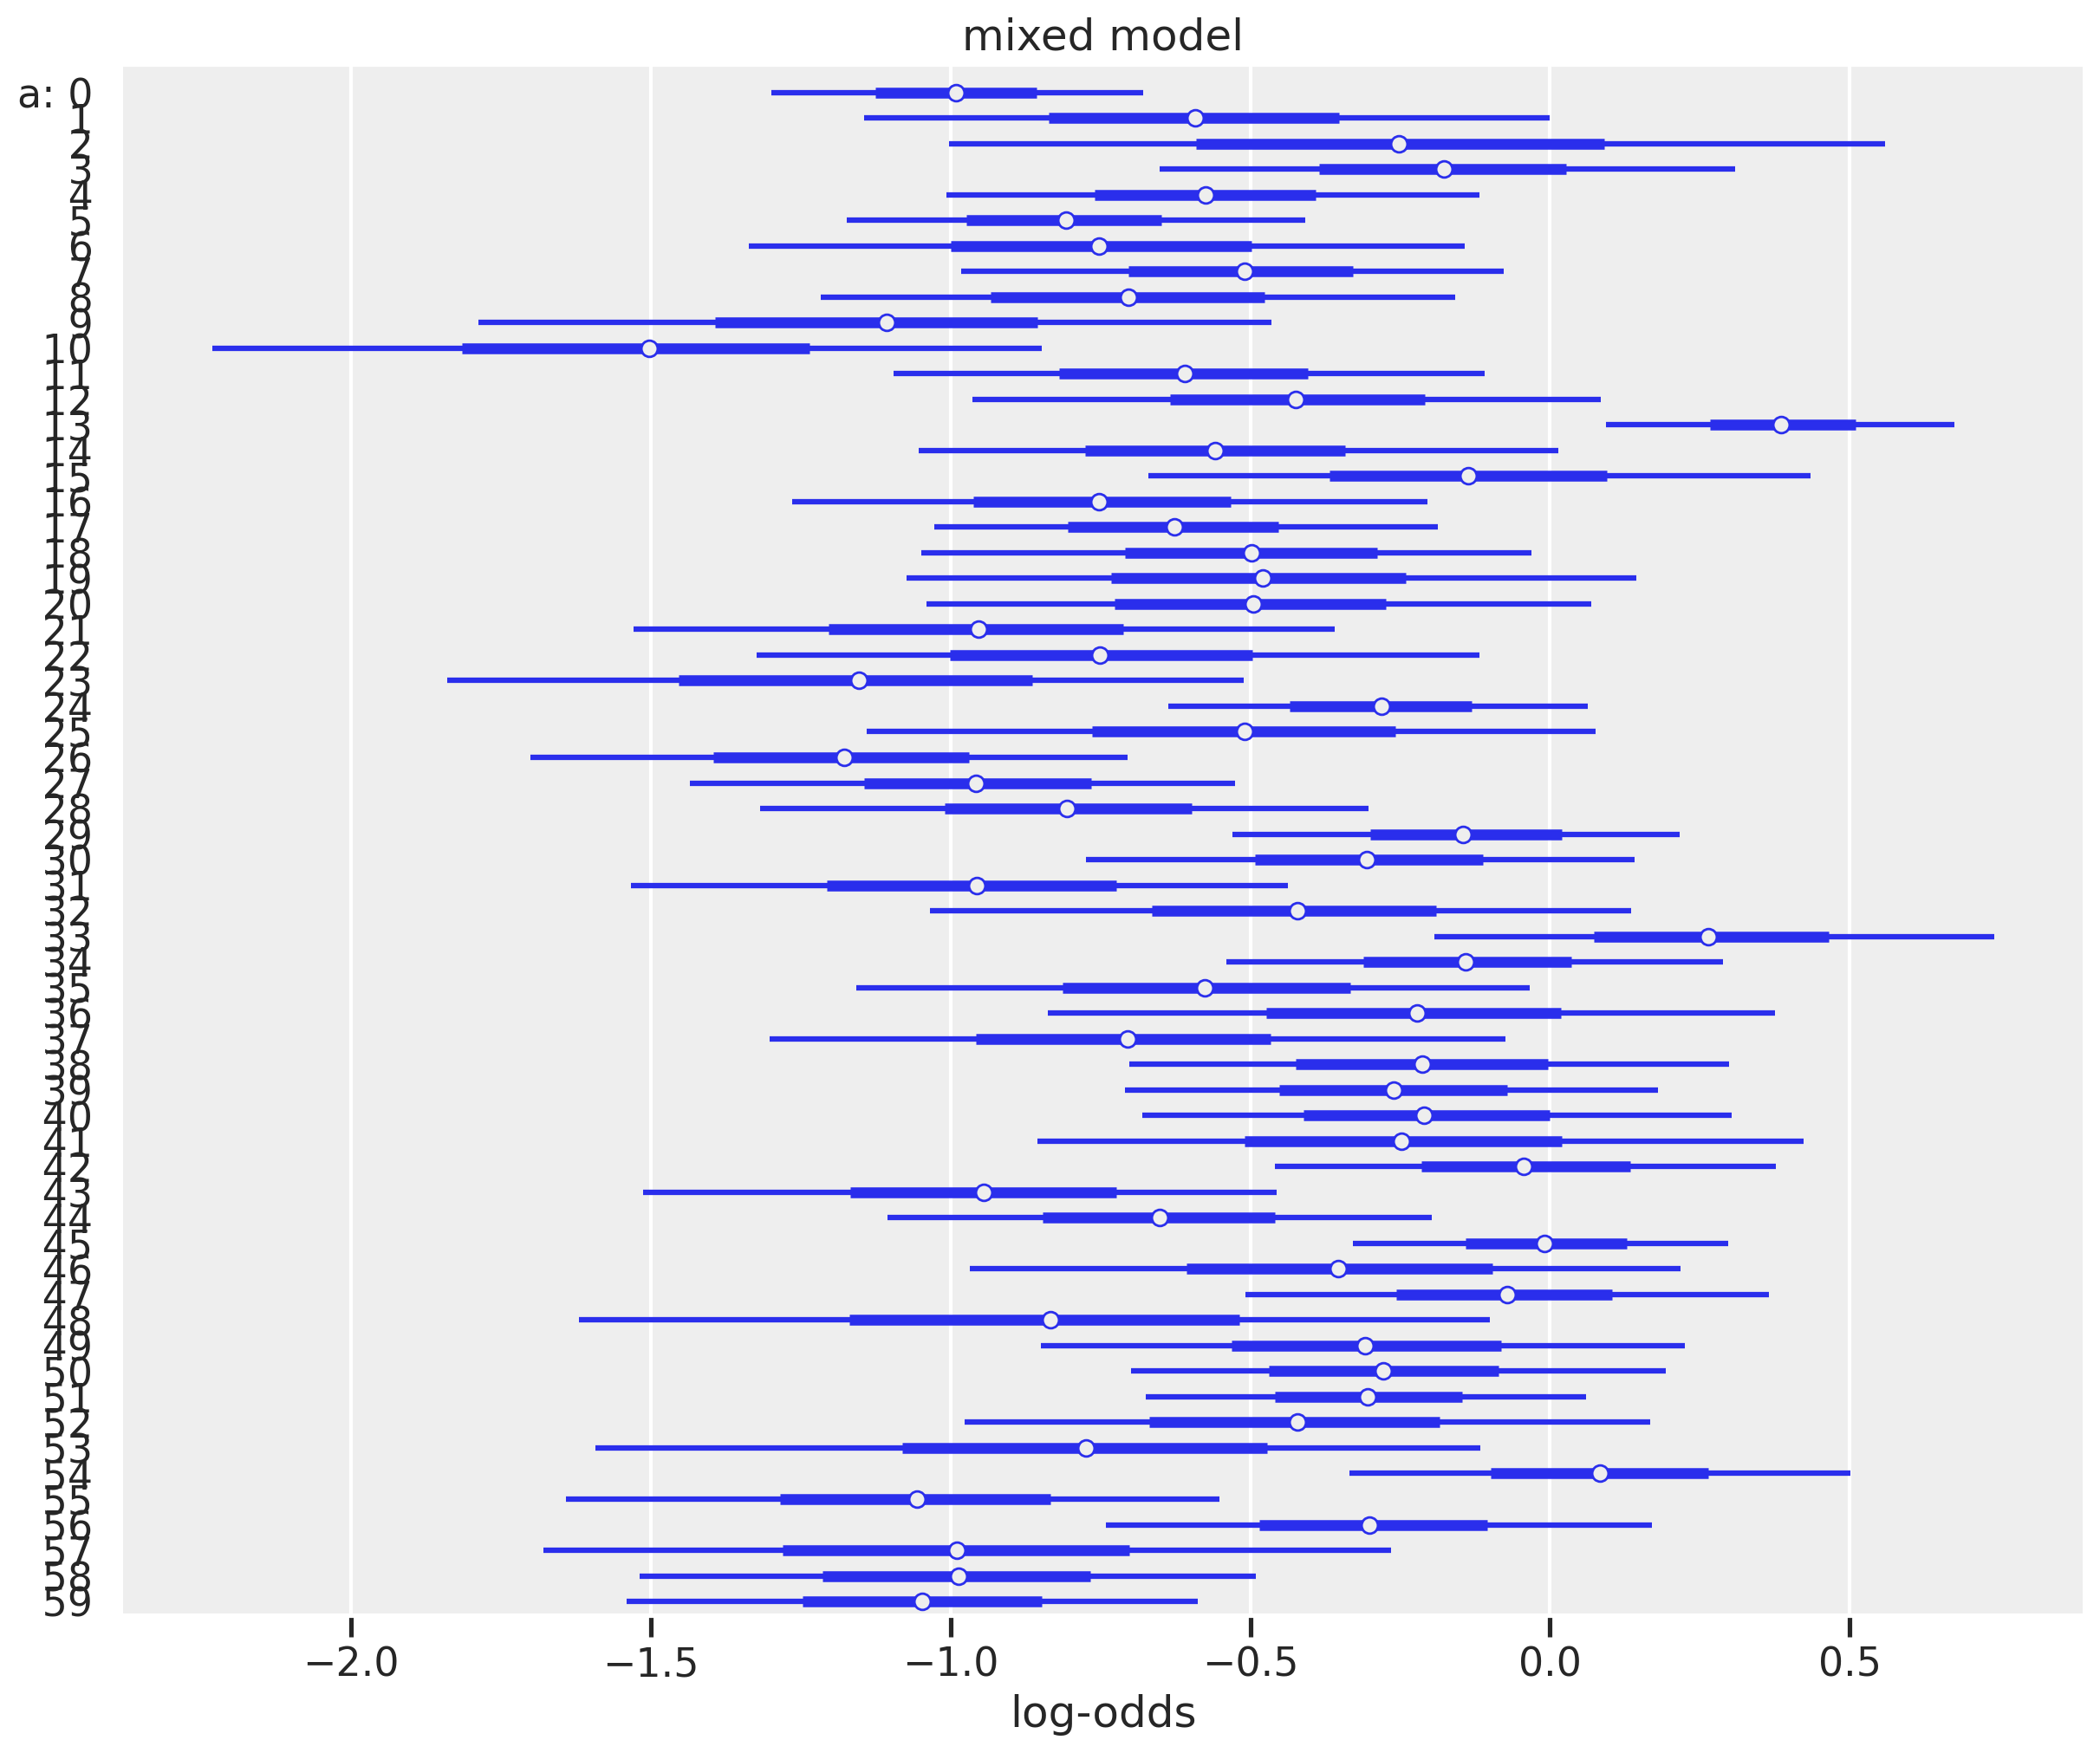

<IPython.core.display.Javascript object>

In [17]:
f, ax1 = plt.subplots(figsize=(12, 10))
az.plot_forest(trace_mme, var_names="a", combined=True, ax=ax1)
ax1.set(xlabel="log-odds", title="mixed model")

Note how the district with index 2 is a lot less confident now. The prediction interval spans log-odds of 0 now. We'll look at this more closely in the comparison.

## Comparison of fixed-effects and mixed-effects models

Let's start off by looking at how the uncertainty for each district is in the fixed-effects versus mixed-effects model for each district.

In [18]:
col2inspect = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = pd.merge(
    az.summary(trace_mfe)[col2inspect],
    az.summary(trace_mme)[col2inspect],
    how="inner",
    left_index=True,
    right_index=True,
)

# Reset index
df_summary.reset_index(inplace=True)

# Add number of women for each district
df_summary["n_women"] = df_bangladesh.groupby("district_code").count().iloc[:, 0]

df_summary.head()

,index,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,n_women
0,a[0],-1.052,0.205,-1.389,-0.730,-0.992,0.198,-1.299,-0.679,117
1,a[1],-0.584,0.452,-1.287,0.134,-0.599,0.360,-1.144,-0.001,20
2,a[2],1.240,1.156,-0.647,2.980,-0.240,0.501,-1.003,0.559,2
3,a[3],-0.003,0.362,-0.572,0.579,-0.179,0.298,-0.652,0.309,30
4,a[4],-0.569,0.330,-1.077,-0.020,-0.577,0.279,-1.007,-0.118,39


<IPython.core.display.Javascript object>

[(0.0, 1.2),
 (0.0, 1.2),
 Text(0.5, 0, 'fixed effects SD'),
 Text(0, 0.5, 'mixed effects SD')]

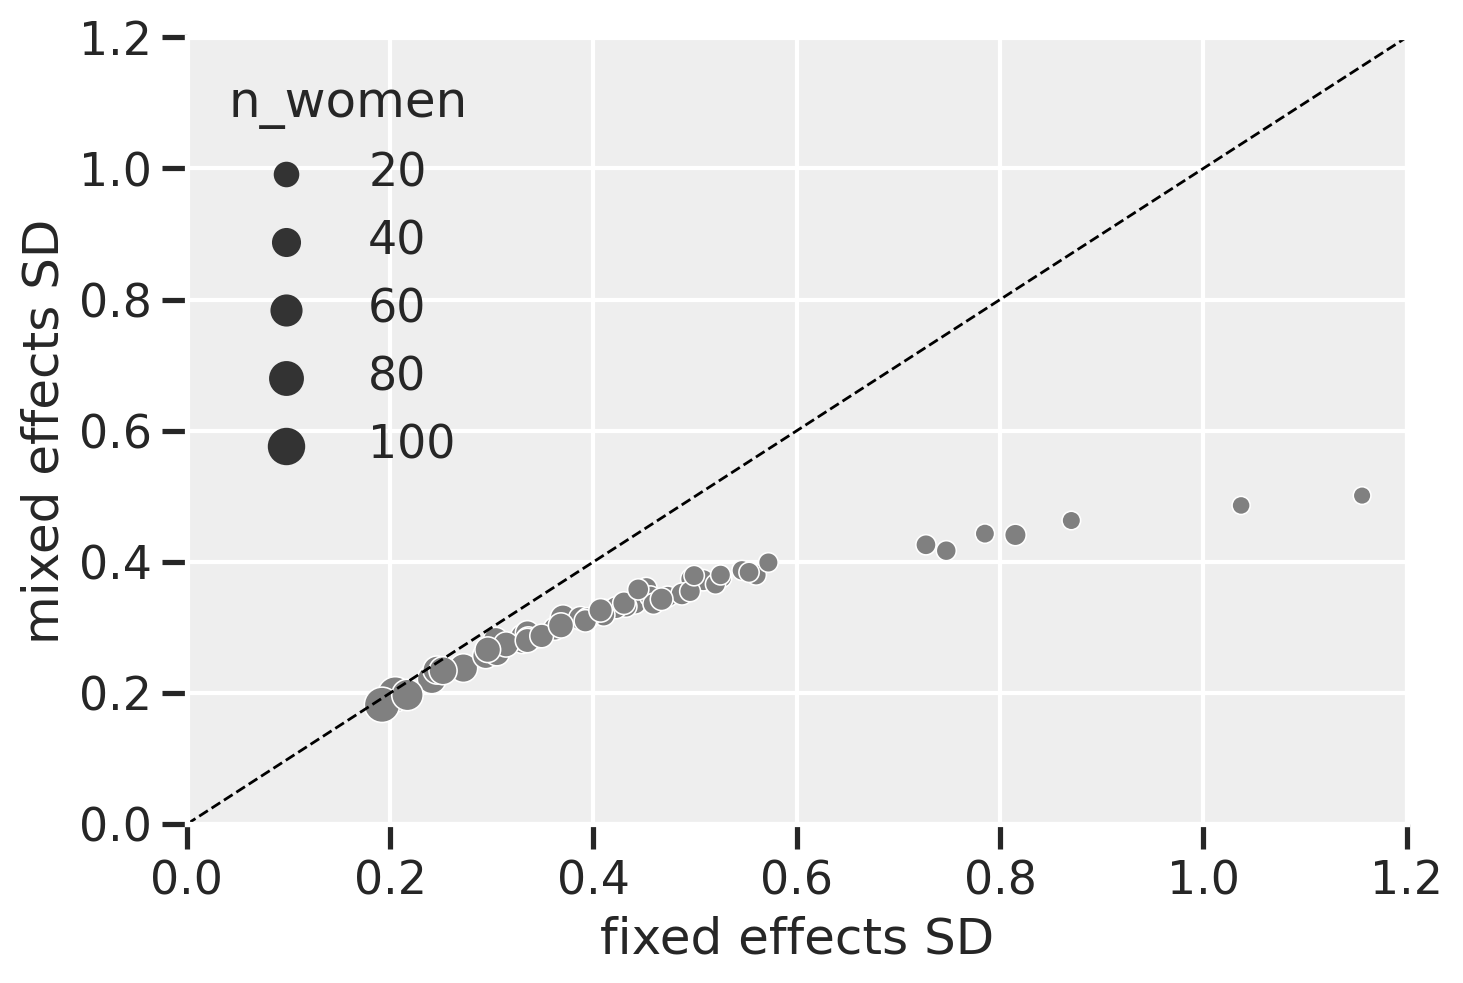

<IPython.core.display.Javascript object>

In [19]:
f, ax1 = plt.subplots()
sns.scatterplot(
    data=df_summary, x="sd_x", y="sd_y", size="n_women", color="gray", ax=ax1
)
ax1.plot([0, 1.2], [0, 1.2], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, 1.2], ylim=[0, 1.2], xlabel="fixed effects SD", ylabel="mixed effects SD"
)

Here, we can see that the fixed effects model shows greater uncertainty, especially when the number of women in each district gets lower. When the number of women is high, the fixed effects shows uncertainty on par with the mixed effects model. Lower uncertainty with mixed effects is due to partial pooling.

Per the homework assignment, let's plot the predicted proportion of women in each district using contraception. We'll use the `logistic` function to transform the log-odds back on the probability scale.

[(-2.0, 60.0),
 (0.0, 1.0),
 Text(0.5, 0, 'district index'),
 Text(0, 0.5, 'proportion predicted\nfor contraception use')]

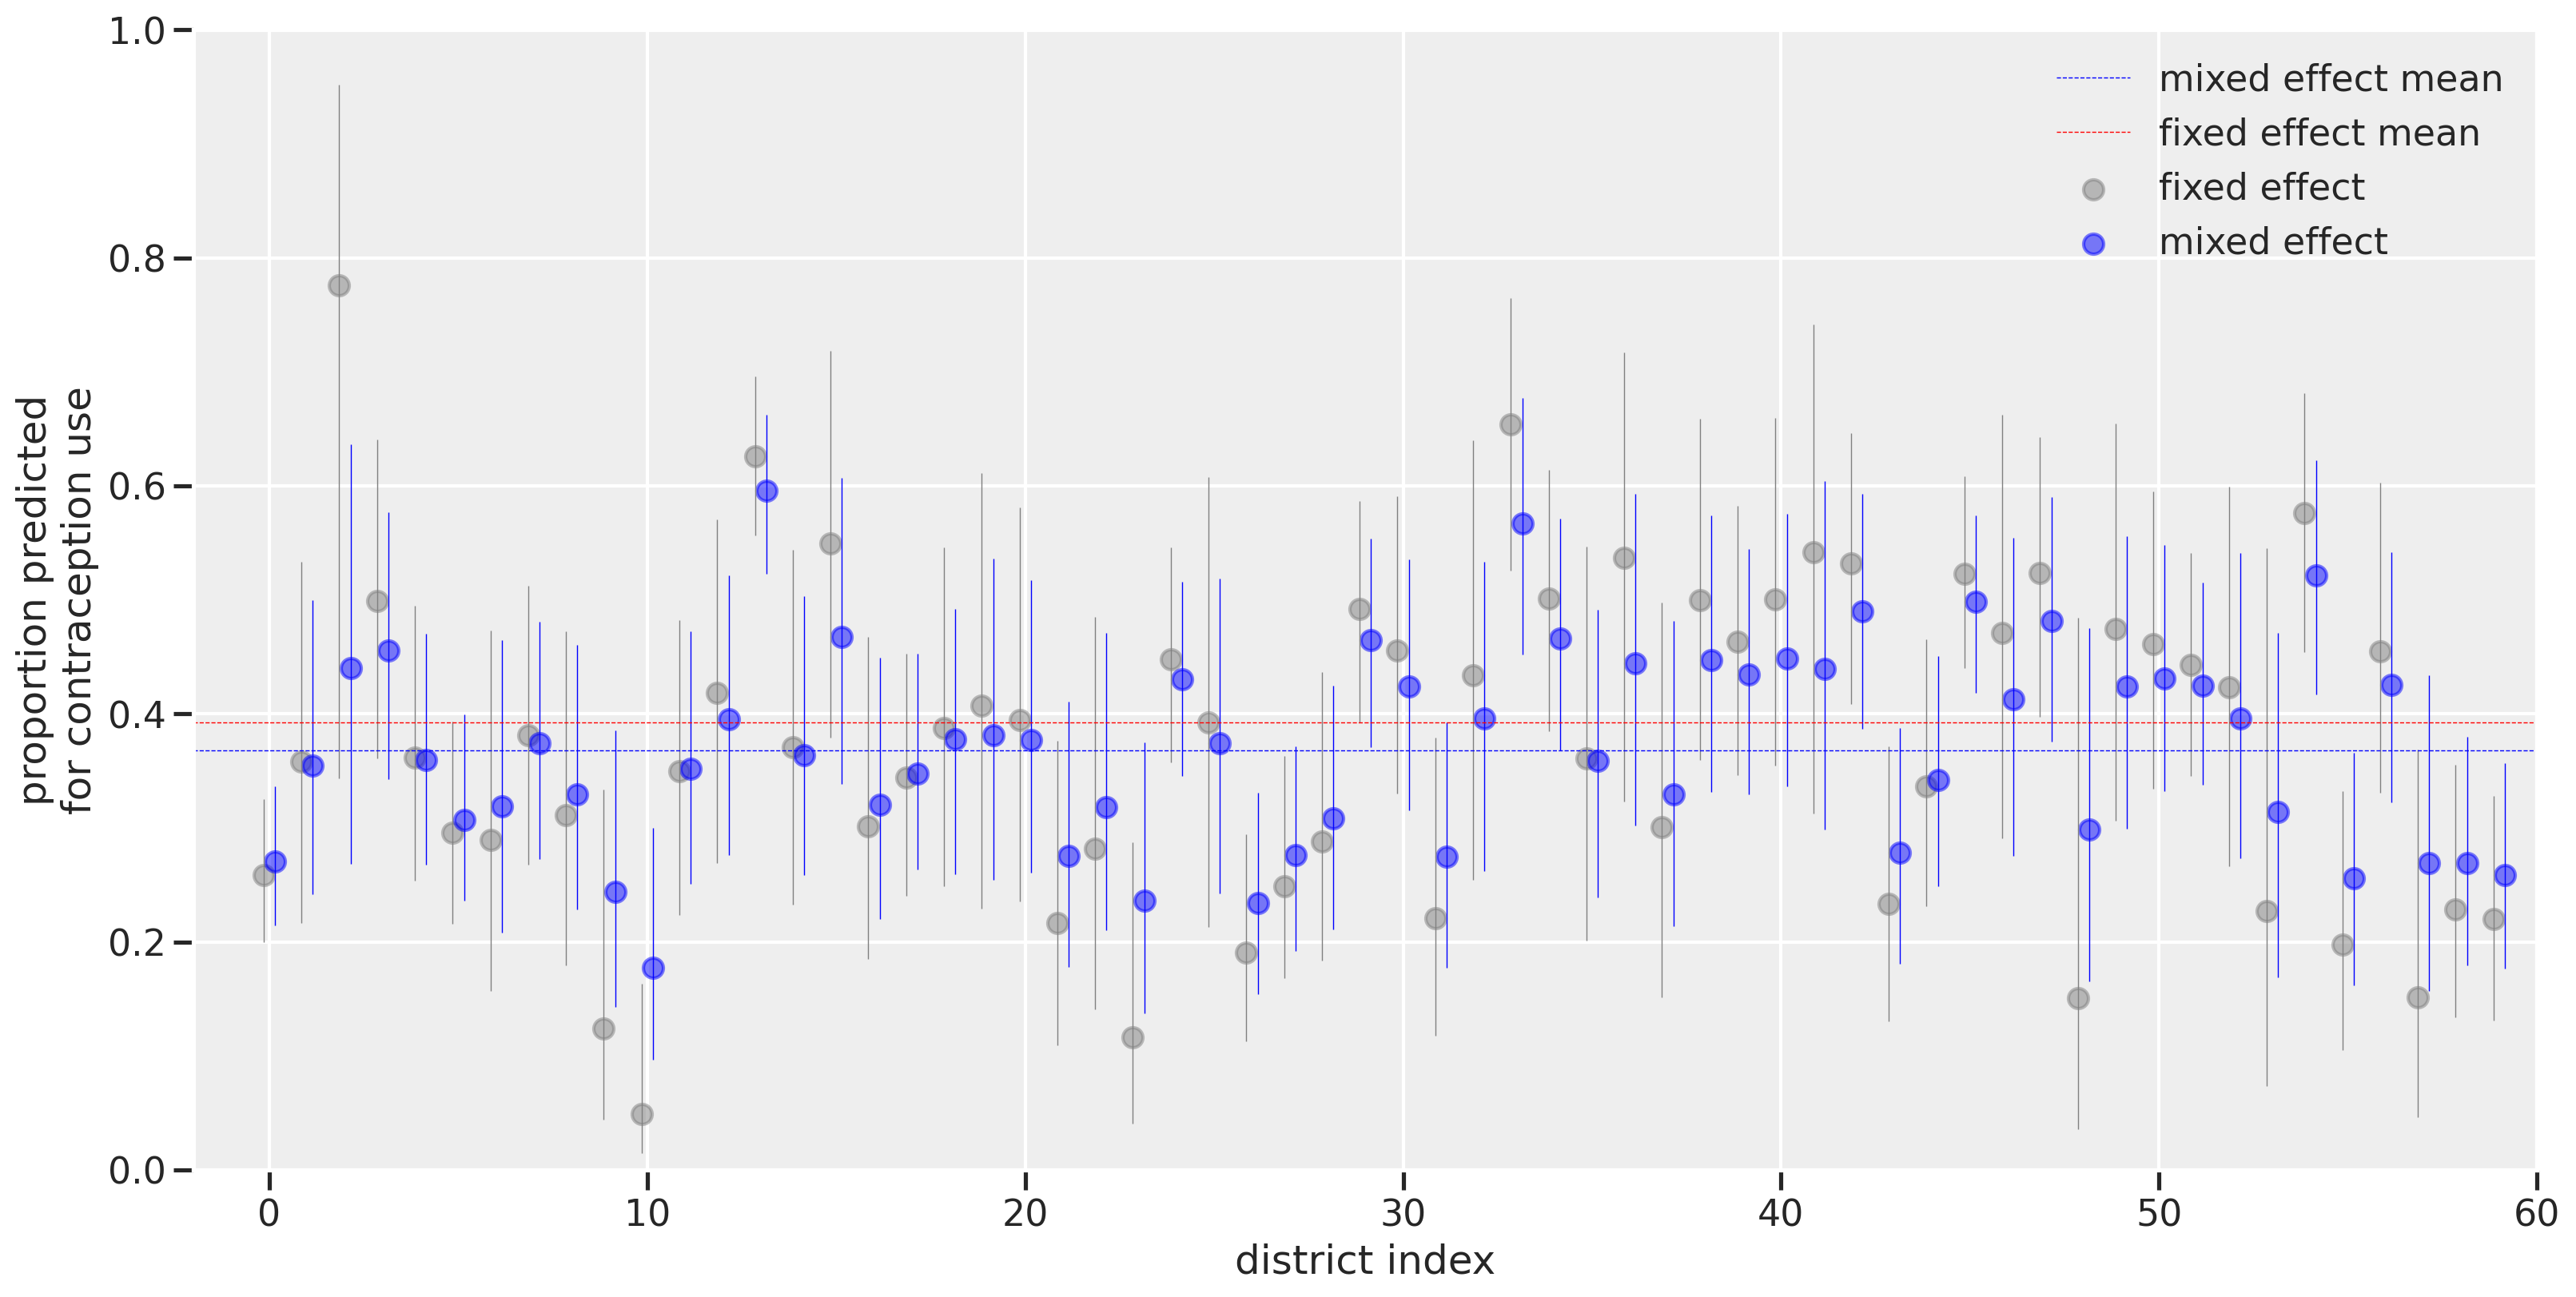

<IPython.core.display.Javascript object>

In [20]:
f, ax1 = plt.subplots(figsize=(16, 8))

# Plot means
ax1.scatter(
    df_summary.index - 0.15,
    logistic(df_summary["mean_x"]),
    color="gray",
    alpha=0.5,
    label="fixed effect",
)
ax1.scatter(
    df_summary.index + 0.15,
    logistic(df_summary["mean_y"]),
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.vlines(
    x=df_summary.index - 0.15,
    ymin=logistic(df_summary["hdi_5.5%_x"]),
    ymax=logistic(df_summary["hdi_94.5%_x"]),
    color="gray",
    linewidth=0.5,
)

ax1.vlines(
    x=df_summary.index + 0.15,
    ymin=logistic(df_summary["hdi_5.5%_y"]),
    ymax=logistic(df_summary["hdi_94.5%_y"]),
    color="blue",
    linewidth=0.5,
)

# Plot average mixed effect line
me_mean = logistic(az.summary(trace_mme).loc["a_bar", "mean"])
ax1.plot(
    [-10, 62],
    [me_mean, me_mean],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
fe_mean = df_bangladesh["use.contraception"].mean()
ax1.plot(
    [-10, 62],
    [fe_mean, fe_mean],
    color="red",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="fixed effect mean",
)

ax1.legend()
ax1.set(
    xlim=[-2, 60],
    ylim=[0, 1],
    xlabel="district index",
    ylabel="proportion predicted\nfor contraception use",
)

## Comparison with homework solution

It largely matched with McElreath's posted solutions. (The colors are flipped when comparing.) But McElreath also transformed all posterior values to probability scale first bfore taking mean.

# Question 1 (14H1)

(homework is problems 14H1-14H3).

Let’s revisit the Bangladesh fertility data, `data(bangladesh)`. Fit a model with both varying intercepts by `district_id` and varying slopes of `urban` by `district_id`. You are still predicting `use.contraception`. Inspect the correlation between the intercepts and slopes. Can you interpret this correlation, in terms of what it tells you about the pattern of contraceptive use in the sample?

It might help to plot the mean (or median) varying effect estimates for both the intercepts and slopes, by district. Then you can visualize the correlation and maybe more easily think through what it means to have a particular correlation. Plotting predicted proportion of women using contraception, with urban women on one axis and rural on the other, might also help.

I was unsure what "varying slopes of urban by `district_id`" meant so I inspected the table.

In [21]:
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_code
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


<IPython.core.display.Javascript object>

In [22]:
df_bangladesh[["district_code", "urban"]].drop_duplicates().sort_values(
    by=["district_code", "urban"]
)

,district_code,urban
63,0,0
0,0,1
117,1,0
137,2,1
150,3,0
...,...,...
1850,57,0
1870,58,0
1860,58,1
1903,59,0


<IPython.core.display.Javascript object>

`Urban` is a categorical index variable which states whether that woman lives in an urban part of that district. From inspection of Chapter 14 code, the setup is similar (R code 14.10 to 14.13).

## Model equation to include varying slopes

This problem is conceptually similar to Chapter 14's cafe example. I'll use that as a template for this problem. One difference though is that this problem has a Binomial likelihood while the cafe problem had a Normal likelihood. I think all we have to change, however, is that we use a link function.

**Model `mvse` equation**

$$C_i \text{ ~ } \text{Binomial}(1, p_i) \tag{likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} + \beta_{\text{district}[i]}U_{[i]} \tag{linear model with link function}$$

Matrix of varying intercepts and slopes and its covariance matrix:


$$\begin{bmatrix}\alpha_{\text{district}} \\ \beta_{\text{district}} \end{bmatrix} \text { ~ MVNormal } \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \text{S} \right)  \tag{population of varying effects} $$

In this prior, we have an intercept term for each district (average contraception use) and the slope (how much it changes if a woman lives in an urban district). Instead of having separate lines for the prior, we put them in the same multivariate normal covariance matrix to allow information sharing between slopes and priors. This allows adaptive regularization of individual district intercepts, their slopes, and the correlation among them. 

The covariance matrix **S** is defined here. (Note: The top left of each array is isn't showing up correctly. It should be \(\sigma_{\alpha}\).)

$$ \text{S} = \left(\begin{array} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{array}\right)  \text{R} \left(\begin{array} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{array}\right) \tag{construct covariance matrix} $$

Why is the covariance matrix set up with separate standard deviations and a correlation matrix? way? Per the text, "splitting the covaraince up into standard deviations and correlations... [will make it] easier to later understand the inferred structure of the varying effects."

Here are the hyperprriors and priors that define the adaptive varying effects prior. In contrast to the cafe example, I'll choose slightly wider prior for \(\beta\), with normal distribution centered around 0 to be a bit more naive to the expected results. My \(\alpha\) will be the same as above. Note also that since we're not using a Normal likelihood, there's no \(\sigma\) term that would be a part of it. We still have the sigmas associated with the alpha and beta in the covariance matrix.

$$ \alpha \text { ~ Normal}(0, 1.5) \tag{prior for average intercept} $$
$$ \beta \text { ~ Normal}(0, 2)  \tag{prior for average slope} $$
$$ \sigma_{alpha} \text{ ~ Exponential}(1) \tag{prior sddev among intercepts} $$
$$ \sigma_{beta} \text{ ~ Exponential}(1) \tag{prior sddev among slopes} $$
$$ \text{R ~ LKJcorr}(2) \tag{prior for correlation matrix} $$

LKJcorr can be thought of as a "regularizing prior for correlation matrices". The LKJcorr's parameter is eta and per the text a value of 2 provides a pretty wide distribution of possible correlations centered over 0 (Figure 14.3).

In [23]:
N_districts = len(df_bangladesh["district_code"].unique())

<IPython.core.display.Javascript object>

In [24]:
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_code
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


<IPython.core.display.Javascript object>

In [26]:
# Used this below
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [98]:
# code modified from repo and adapted for binomial likelihood

with pm.Model() as mvse:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_district = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", mu=0, sd=1.5)  # used same from previous problem
    b = pm.Normal("b", mu=0, sd=2)  # use something conservative

    ab_district = pm.MvNormal(
        "ab_district", mu=tt.stack([a, b]), chol=chol, shape=(N_districts, 2)
    )  # population of varying effects
    # shape needs to be (N_districts, 2) because we're getting back both a and b for each district

    # originally written link function
    # prevented p from being included as a parameter I could access in posterior distribution
    #     p = pm.math.invlogit(
    #         ab_district[df_bangladesh["district_code"], 0]
    #         + ab_district[df_bangladesh["district_code"], 1] * df_bangladesh["urban"]
    #     )

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_district[df_bangladesh["district_code"], 0]
            + ab_district[df_bangladesh["district_code"], 1] * df_bangladesh["urban"]
        ),
    )

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mvse = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_district, b, a, chol_cov]
INFO:pymc3:NUTS: [ab_district, b, a, chol_cov]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [99]:
az.summary(trace_mvse)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.710,0.101,-0.879,-0.555,0.002,0.001,2554.0,2550.0,2556.0,2752.0,1.0
b,0.709,0.173,0.424,0.970,0.004,0.003,1770.0,1770.0,1771.0,2402.0,1.0
"ab_district[0,0]",-1.542,0.316,-2.051,-1.045,0.006,0.004,3243.0,3123.0,3293.0,2857.0,1.0
"ab_district[0,1]",1.066,0.391,0.420,1.657,0.007,0.005,2826.0,2550.0,2868.0,2751.0,1.0
"ab_district[1,0]",-0.677,0.371,-1.296,-0.103,0.006,0.005,3652.0,2732.0,3686.0,2544.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
p[1929],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1930],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1931],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1932],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0


<IPython.core.display.Javascript object>

## Inspection of correlation between slopes and prior

This will tell us whether living in an urban area would influence the likelihood of taking contraception. A positive correlation would tell us that across all districts with an already high average probability of taking contraception (high slopes), even more would take contraception in an urban area (high intercept). If the correlation were negative, that means women living in districts with high average probability would be *less likely* to take contraception if they were in an urban area.

Let's plot the intercepts and slopes to see what the relationship looks like. First, let's see where we can find these values in the parameters.

In [100]:
az.summary(trace_mvse, var_names="ab_district").index

Index(['ab_district[0,0]', 'ab_district[0,1]', 'ab_district[1,0]',
       'ab_district[1,1]', 'ab_district[2,0]', 'ab_district[2,1]',
       'ab_district[3,0]', 'ab_district[3,1]', 'ab_district[4,0]',
       'ab_district[4,1]',
       ...
       'ab_district[55,0]', 'ab_district[55,1]', 'ab_district[56,0]',
       'ab_district[56,1]', 'ab_district[57,0]', 'ab_district[57,1]',
       'ab_district[58,0]', 'ab_district[58,1]', 'ab_district[59,0]',
       'ab_district[59,1]'],
      dtype='object', length=120)

<IPython.core.display.Javascript object>

It looks like the district is represented in the 0th position of the index and there's two terms associate with each. The first term is the alpha term (intercepts) and the second term is the beta term (slopes). We'll plot the means of these parameters with intercepts in a scatter plot.

In [101]:
# Let's turn it into a dataframe for plotting
df_ab_district = az.summary(trace_mvse, var_names="ab_district")
df_ab_district.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"ab_district[0,0]",-1.542,0.316,-2.051,-1.045,0.006,0.004,3243.0,3123.0,3293.0,2857.0,1.0
"ab_district[0,1]",1.066,0.391,0.420,1.657,0.007,0.005,2826.0,2550.0,2868.0,2751.0,1.0
"ab_district[1,0]",-0.677,0.371,-1.296,-0.103,0.006,0.005,3652.0,2732.0,3686.0,2544.0,1.0
"ab_district[1,1]",0.686,0.672,-0.350,1.775,0.011,0.009,3832.0,2573.0,3811.0,2866.0,1.0
"ab_district[2,0]",-0.686,0.583,-1.579,0.221,0.010,0.008,3254.0,2808.0,3264.0,2690.0,1.0


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'intercepts (a_district)'),
 Text(0, 0.5, 'slopes (b_district)'),
 Text(0.5, 1.0, 'intercepts vs. slopes')]

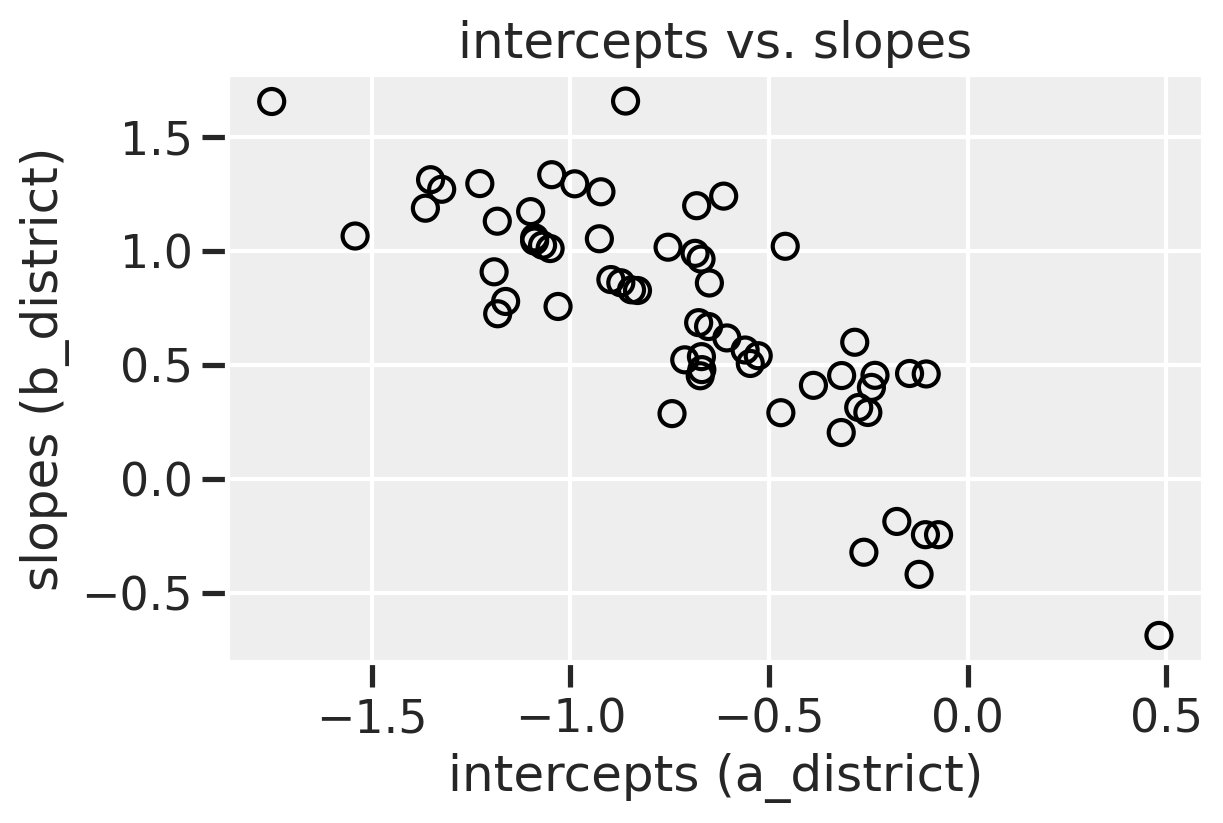

<IPython.core.display.Javascript object>

In [102]:
# Can add concentric circles later
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
for i in range(60):
    ax1.scatter(
        df_ab_district.loc["ab_district[" + str(i) + ",0]", "mean"],
        df_ab_district.loc["ab_district[" + str(i) + ",1]", "mean"],
        facecolors="none",
        edgecolors="black",
    )

ax1.set(
    xlabel="intercepts (a_district)",
    ylabel="slopes (b_district)",
    title="intercepts vs. slopes",
)

We see a negative correlation, which is also confirmed by inspecting the posterior distribution for the value for rho in the Cholevsky correlation matrix.

In [103]:
# Inspect off-diagonal values
az.summary(trace_mvse, var_names="chol_cov_corr")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"chol_cov_corr[0,1]",-0.654,0.167,-0.905,-0.432,0.006,0.004,703.0,703.0,691.0,1231.0,1.0
"chol_cov_corr[1,0]",-0.654,0.167,-0.905,-0.432,0.006,0.004,703.0,703.0,691.0,1231.0,1.0
"chol_cov_corr[1,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,3979.0,3973.0,1.0


<IPython.core.display.Javascript object>

Let's plot the prior and posterior distribution of the correlation between intercepts and slopes.

In [104]:
trace_mvse_df = trace_mvse.to_dataframe()

<IPython.core.display.Javascript object>

In [106]:
[print(col) for col in trace_mvse_df.columns]

chain
draw
('posterior', 'a')
('posterior', 'b')
('posterior', 'ab_district[0,0]', 0, 0)
('posterior', 'ab_district[0,1]', 0, 1)
('posterior', 'ab_district[1,0]', 1, 0)
('posterior', 'ab_district[1,1]', 1, 1)
('posterior', 'ab_district[10,0]', 10, 0)
('posterior', 'ab_district[10,1]', 10, 1)
('posterior', 'ab_district[11,0]', 11, 0)
('posterior', 'ab_district[11,1]', 11, 1)
('posterior', 'ab_district[12,0]', 12, 0)
('posterior', 'ab_district[12,1]', 12, 1)
('posterior', 'ab_district[13,0]', 13, 0)
('posterior', 'ab_district[13,1]', 13, 1)
('posterior', 'ab_district[14,0]', 14, 0)
('posterior', 'ab_district[14,1]', 14, 1)
('posterior', 'ab_district[15,0]', 15, 0)
('posterior', 'ab_district[15,1]', 15, 1)
('posterior', 'ab_district[16,0]', 16, 0)
('posterior', 'ab_district[16,1]', 16, 1)
('posterior', 'ab_district[17,0]', 17, 0)
('posterior', 'ab_district[17,1]', 17, 1)
('posterior', 'ab_district[18,0]', 18, 0)
('posterior', 'ab_district[18,1]', 18, 1)
('posterior', 'ab_district[19,0]', 

('posterior', 'p[716]', 716)
('posterior', 'p[717]', 717)
('posterior', 'p[718]', 718)
('posterior', 'p[719]', 719)
('posterior', 'p[71]', 71)
('posterior', 'p[720]', 720)
('posterior', 'p[721]', 721)
('posterior', 'p[722]', 722)
('posterior', 'p[723]', 723)
('posterior', 'p[724]', 724)
('posterior', 'p[725]', 725)
('posterior', 'p[726]', 726)
('posterior', 'p[727]', 727)
('posterior', 'p[728]', 728)
('posterior', 'p[729]', 729)
('posterior', 'p[72]', 72)
('posterior', 'p[730]', 730)
('posterior', 'p[731]', 731)
('posterior', 'p[732]', 732)
('posterior', 'p[733]', 733)
('posterior', 'p[734]', 734)
('posterior', 'p[735]', 735)
('posterior', 'p[736]', 736)
('posterior', 'p[737]', 737)
('posterior', 'p[738]', 738)
('posterior', 'p[739]', 739)
('posterior', 'p[73]', 73)
('posterior', 'p[740]', 740)
('posterior', 'p[741]', 741)
('posterior', 'p[742]', 742)
('posterior', 'p[743]', 743)
('posterior', 'p[744]', 744)
('posterior', 'p[745]', 745)
('posterior', 'p[746]', 746)
('posterior', 'p[747

('log_likelihood', 'c[324]', 324)
('log_likelihood', 'c[325]', 325)
('log_likelihood', 'c[326]', 326)
('log_likelihood', 'c[327]', 327)
('log_likelihood', 'c[328]', 328)
('log_likelihood', 'c[329]', 329)
('log_likelihood', 'c[32]', 32)
('log_likelihood', 'c[330]', 330)
('log_likelihood', 'c[331]', 331)
('log_likelihood', 'c[332]', 332)
('log_likelihood', 'c[333]', 333)
('log_likelihood', 'c[334]', 334)
('log_likelihood', 'c[335]', 335)
('log_likelihood', 'c[336]', 336)
('log_likelihood', 'c[337]', 337)
('log_likelihood', 'c[338]', 338)
('log_likelihood', 'c[339]', 339)
('log_likelihood', 'c[33]', 33)
('log_likelihood', 'c[340]', 340)
('log_likelihood', 'c[341]', 341)
('log_likelihood', 'c[342]', 342)
('log_likelihood', 'c[343]', 343)
('log_likelihood', 'c[344]', 344)
('log_likelihood', 'c[345]', 345)
('log_likelihood', 'c[346]', 346)
('log_likelihood', 'c[347]', 347)
('log_likelihood', 'c[348]', 348)
('log_likelihood', 'c[349]', 349)
('log_likelihood', 'c[34]', 34)
('log_likelihood', '

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [107]:
# Get posterior of the rho value
trace_mvse_df[("posterior", "chol_cov_corr[0,1]", 0, 1)]

0      -0.781319
1      -0.863538
2      -0.531439
3      -0.581260
4      -0.581571
          ...   
3995   -0.802648
3996   -0.828686
3997   -0.810492
3998   -0.821354
3999   -0.818089
Name: (posterior, chol_cov_corr[0,1], 0, 1), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'rho (correlation factor)'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'Distribution of correlation values')]

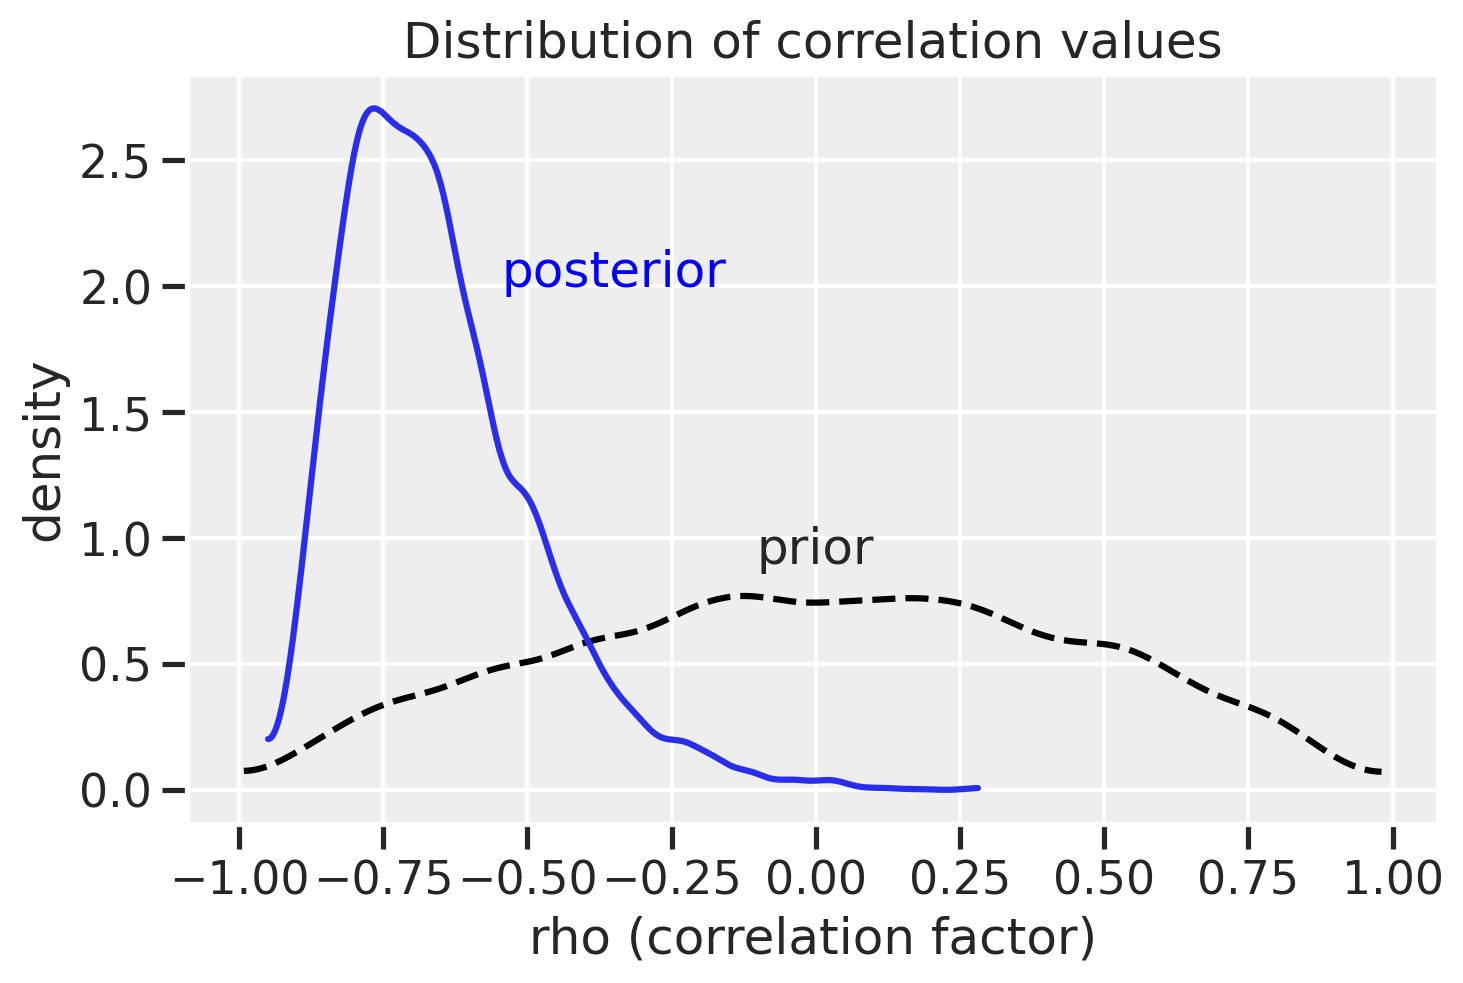

<IPython.core.display.Javascript object>

In [108]:
# Code informed/modified from repo
f, ax1 = plt.subplots()

# prior
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
az.plot_kde(R, plot_kwargs={"color": "k", "linestyle": "--"}, ax=ax1)
ax1.text(0, 0.9, "prior", horizontalalignment="center")

# posterior
az.plot_kde(trace_mvse_df[("posterior", "chol_cov_corr[0,1]", 0, 1)], ax=ax1)
ax1.text(-0.35, 2.0, "posterior", horizontalalignment="center", color="blue")

ax1.set(
    xlabel="rho (correlation factor)",
    ylabel="density",
    title="Distribution of correlation values",
)

## Plot predicted proportion of women using contraception for each district

Scatterplot of urban vs. rural.

### Sidebar: How come I can't get "p"?  (START)

I have trouble getting p. Why isn't it a parameter that was kept? Maybe how I setup my model?

Here's how I set it up before and how I'll try to do it:

```
# link function
p = pm.math.invlogit(a[df_bangladesh["district_code"]])

# new link function
p = pm.Deterministic("p", pm.math.invlogit(a[df_bangladesh["district_code"]]))
```

In [95]:
# multilevel model, non-centered version
with pm.Model() as m_13_2sr2:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha priors for each district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    # p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # new link function
    p = pm.Deterministic("p", pm.math.invlogit(a[df_bangladesh["district_code"]]))

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mme2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [96]:
az.summary(trace_mme2, var_names="p")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[1],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[2],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[3],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
p[4],0.272,0.039,0.214,0.337,0.000,0.000,6065.0,5885.0,5973.0,2419.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
p[1929],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0
p[1930],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0
p[1931],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0
p[1932],0.263,0.057,0.171,0.351,0.001,0.001,6079.0,5593.0,6009.0,2550.0,1.0


<IPython.core.display.Javascript object>

Yes, I think the way I wrote the link function influenced whether it would be part of the posterior distribution that I can access.

### Sidebar: How come I can't get "p"?  (END)

After the above lesson, I re-ran the model with the right implementation. Here are the posterior mean values.

In [111]:
df_summary_p = az.summary(trace_mvse, var_names="p")
df_summary_p

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[1],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[2],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[3],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
p[4],0.385,0.056,0.292,0.469,0.001,0.001,1942.0,1866.0,1951.0,1558.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
p[1929],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1930],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1931],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0
p[1932],0.240,0.063,0.132,0.330,0.001,0.001,3924.0,3701.0,3912.0,2549.0,1.0


<IPython.core.display.Javascript object>

In [133]:
df_bangladesh_temp = df_bangladesh.copy()
df_bangladesh_temp["post_p"] = df_summary_p.iloc[:, 0].tolist()

<IPython.core.display.Javascript object>

In [136]:
df_bangladesh_temp.sort_values(by=["district_code", "urban"])

,woman,district,use.contraception,living.children,age.centered,urban,district_code,post_p
63,64,1,0,4,11.4400,0,0,0.181
64,65,1,0,4,-4.5599,0,0,0.181
65,66,1,0,4,10.4400,0,0,0.181
66,67,1,0,4,4.4400,0,0,0.181
67,68,1,0,4,-3.5599,0,0,0.181
...,...,...,...,...,...,...,...,...
1898,1899,61,1,4,-3.5599,1,59,0.393
1899,1900,61,0,1,-12.5600,1,59,0.393
1900,1901,61,0,4,12.4400,1,59,0.393
1901,1902,61,0,3,0.4400,1,59,0.393


<IPython.core.display.Javascript object>

In [141]:
df_bangladesh_temp[df_bangladesh_temp.loc[:, "district_code"] == 0]

,woman,district,use.contraception,living.children,age.centered,urban,district_code,post_p
0,1,1,0,4,18.4400,1,0,0.385
1,2,1,0,1,-5.5599,1,0,0.385
2,3,1,0,3,1.4400,1,0,0.385
3,4,1,0,4,8.4400,1,0,0.385
4,5,1,0,1,-13.5590,1,0,0.385
...,...,...,...,...,...,...,...,...
112,113,1,0,3,3.4400,0,0,0.181
113,114,1,0,1,-1.5599,0,0,0.181
114,115,1,0,4,3.4400,0,0,0.181
115,116,1,0,4,-1.5599,0,0,0.181


<IPython.core.display.Javascript object>

The posterior prediction is the same for each woman in the same district and urban code. We can get the fixed and multilevel model estimates this way.

In [145]:
df_bangladesh_temp2 = df_bangladesh_temp.groupby(["district_code", "urban"]).mean(
    "use.contraception"
)[["use.contraception", "post_p"]]

df_bangladesh_temp2.reset_index(inplace=True)

df_bangladesh_temp2.columns = [
    "district_code",
    "urban",
    "use.contraception_fixed",
    "use.contraception_mixed",
]

df_bangladesh_temp2

,district_code,urban,use.contraception_fixed,use.contraception_mixed
0,0,0,0.129630,0.181
1,0,1,0.365079,0.385
2,1,0,0.350000,0.342
3,2,1,1.000000,0.570
4,3,0,0.263158,0.303
...,...,...,...,...
97,57,0,0.100000,0.245
98,58,0,0.181818,0.245
99,58,1,0.300000,0.410
100,59,0,0.193548,0.240


<IPython.core.display.Javascript object>

In [158]:
df_bangladesh_temp2["district_code"].value_counts()

0     2
26    2
28    2
29    2
32    2
33    2
34    2
35    2
37    2
38    2
39    2
40    2
41    2
42    2
44    2
45    2
46    2
47    2
49    2
50    2
51    2
54    2
55    2
56    2
58    2
27    2
30    2
59    2
17    2
7     2
11    2
12    2
24    2
13    2
14    2
15    2
18    2
20    2
5     2
4     2
3     2
8     2
48    1
52    1
6     1
53    1
57    1
2     1
25    1
9     1
10    1
16    1
36    1
19    1
21    1
22    1
31    1
1     1
23    1
43    1
Name: district_code, dtype: int64

<IPython.core.display.Javascript object>

Note that not all districts have both urban and rural so I'll just stick to those that have both.

In [165]:
districts_with2 = (
    df_bangladesh_temp2["district_code"]
    .value_counts()[(df_bangladesh_temp2["district_code"].value_counts() == 2)]
    .index
)

<IPython.core.display.Javascript object>

In [167]:
df_bangladesh_temp3 = df_bangladesh_temp2.loc[
    df_bangladesh_temp2["district_code"].isin(districts_with2), :
]

<IPython.core.display.Javascript object>

In [168]:
df_bangladesh_temp3.shape

(84, 4)

<IPython.core.display.Javascript object>

In [170]:
df_bangladesh_temp3["district_code"].unique()

array([ 0,  3,  4,  5,  7,  8, 11, 12, 13, 14, 15, 17, 18, 20, 24, 26, 27,
       28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47,
       49, 50, 51, 54, 55, 56, 58, 59])

<IPython.core.display.Javascript object>

[(-0.05, 1.05),
 (-0.05, 1.05),
 Text(0.5, 0, 'proportion of rural women\nusing contraception'),
 Text(0, 0.5, 'proportion of urban women\nusing contraception'),
 Text(0.5, 1.0, 'fixed effects model')]

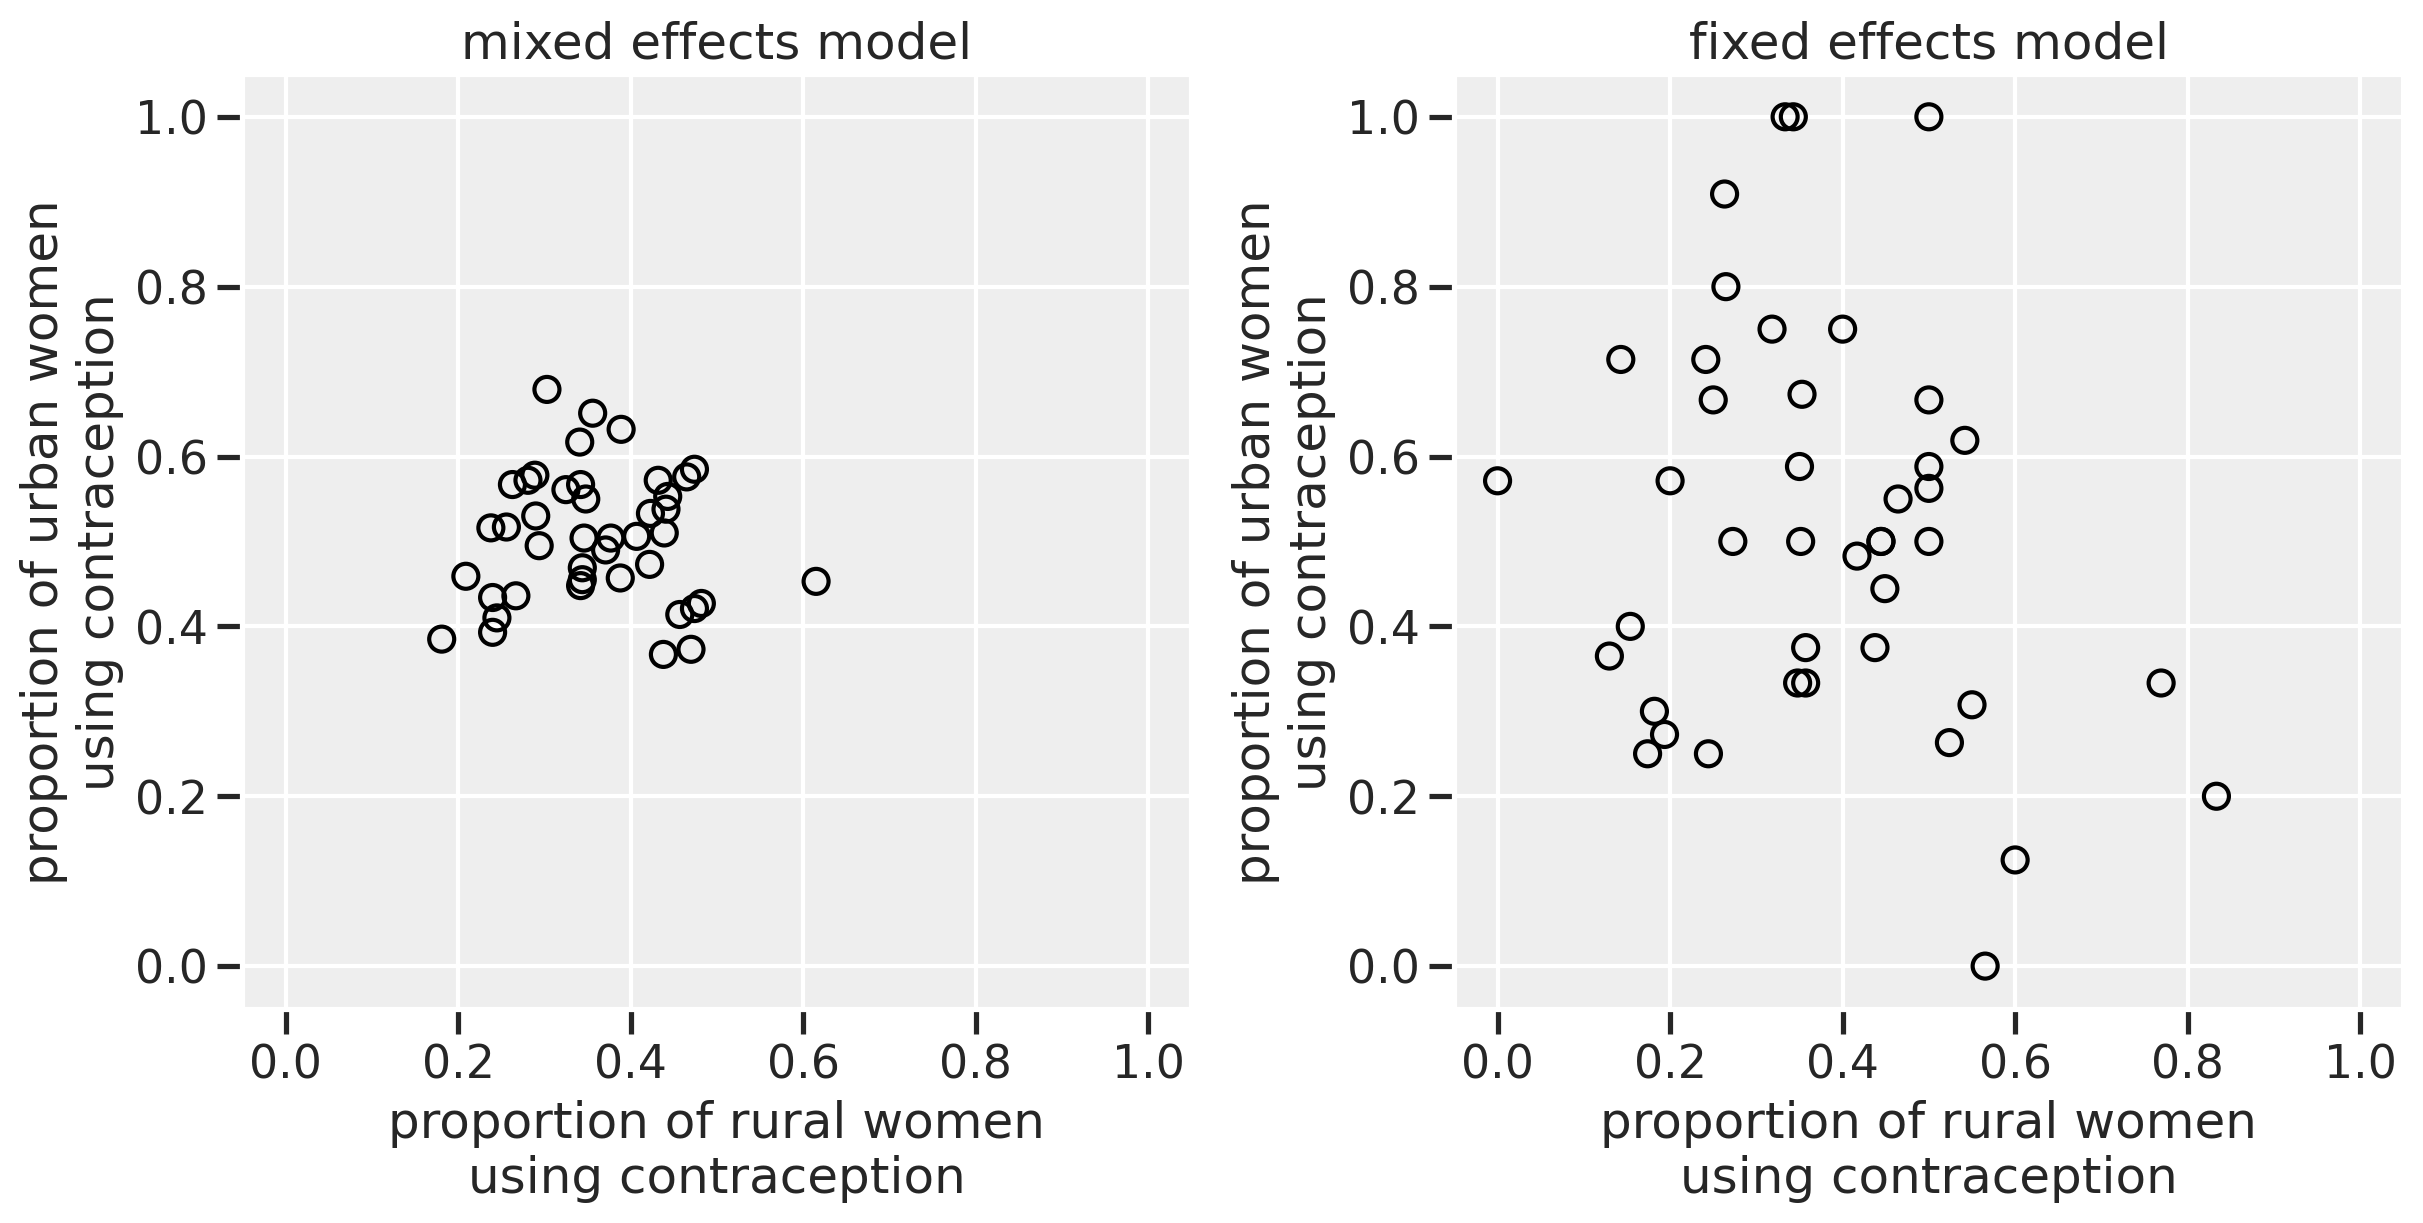

<IPython.core.display.Javascript object>

In [188]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for district in df_bangladesh_temp3["district_code"].unique():
    bool_row_urban = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 1
    )
    bool_row_rural = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 0
    )

    # rural on x-xaxis and urban on y-axis to match solutions
    ax1.scatter(
        df_bangladesh_temp3.loc[bool_row_rural, "use.contraception_mixed"],
        df_bangladesh_temp3.loc[bool_row_urban, "use.contraception_mixed"],
        facecolors="none",
        edgecolors="black",
    )

ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="proportion of rural women\nusing contraception",
    ylabel="proportion of urban women\nusing contraception",
    title="mixed effects model",
)


for district in df_bangladesh_temp3["district_code"].unique():
    bool_row_urban = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 1
    )
    bool_row_rural = (df_bangladesh_temp3["district_code"] == district) & (
        df_bangladesh_temp2["urban"] == 0
    )

    # rural on x-xaxis and urban on y-axis to match solutions
    ax2.scatter(
        df_bangladesh_temp3.loc[bool_row_rural, "use.contraception_fixed"],
        df_bangladesh_temp3.loc[bool_row_urban, "use.contraception_fixed"],
        facecolors="none",
        edgecolors="black",
    )

ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="proportion of rural women\nusing contraception",
    ylabel="proportion of urban women\nusing contraception",
    title="fixed effects model",
)

Note how the mixed effects model imposes a lot of shrinkage by accounting for the sample size differences with each district.

## Comparing with online solutions

I got largely the same results. I could've also looked at the \(\alpha\) and \(\beta\) averages for a quicker snapshot. There's also some more explanation in terms of interpretation: "Since the slope is the difference between urban and non-urban areas, you can see this as saying that districts with high use in rural areas
have urban areas that aren’t as different."

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>